In [51]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import seaborn as sns
import time

### Parámetros del sistema y configuración de simulación

In [52]:
# Áreas de la sección transversal de los tanques [cm^2]
A1, A3 = 28.0, 28.0
A2, A4 = 32.0, 32.0

# Áreas de los orificios de salida [cm^2]
a1, a3 = 0.071, 0.071
a2, a4 = 0.057, 0.057

# Constantes de las bombas [cm^3/Vs]
k1, k2 = 3.33, 3.35

# Parámetros de flujo dividido (adimensional)
gamma1, gamma2 = 0.70, 0.60

# Gravedad [cm/s^2]
g = 981.0

# Tiempo de simulación
dt = 0.05
T_sim = 5000
t = np.arange(0, T_sim + dt, dt)
n = len(t)

# Condiciones iniciales de las alturas [cm]
h0 = np.array([12.4, 12.7, 1.8, 1.4])

# Ruido blanco y parámetros de la señal
noise_input_std = 0.06
noise_output_std = 0.06

# Rango de duración de los escalones
t_cambio_min = 50
t_cambio_max = 50

# Límites de voltaje para las dos bombas [V]
V_min = 0.0
V_max = 6.0

## Función del sistema dinámico no lineal de cuatro tanques

In [53]:
def nonlinear_ode_system_model(t, h, u_func, A1, A2, A3, A4, a1, a2, a3, a4, g, k1, k2, gamma1, gamma2):
    # Desempaquetado del vector de estados (niveles h1, h2, h3, h4)
    h1, h2, h3, h4 = h
    eps = 1e-6

    # Alturas no negativas para el cálculo de la raíz cuadrada
    h_seguro = np.maximum(h, eps)
    h1_s, h2_s, h3_s, h4_s = h_seguro

    v = u_func(t)
    v1, v2 = v

    # --- Ecuaciones diferenciales del sistema de cuatro tanques ---
    dh1dt = -(a1 / A1) * np.sqrt(2 * g * h1_s) + (a3 / A1) * np.sqrt(2 * g * h3_s) + (gamma1 * k1 / A1) * v1
    dh2dt = -(a2 / A2) * np.sqrt(2 * g * h2_s) + (a4 / A2) * np.sqrt(2 * g * h4_s) + (gamma2 * k2 / A2) * v2
    dh3dt = -(a3 / A3) * np.sqrt(2 * g * h3_s) + ((1 - gamma2) * k2 / A3) * v2
    dh4dt = -(a4 / A4) * np.sqrt(2 * g * h4_s) + ((1 - gamma1) * k1 / A4) * v1

    # Vector de derivadas de estado
    return [dh1dt, dh2dt, dh3dt, dh4dt]

## Creación de señales PBRS de entrada

In [54]:
# Ajuste de parámetros de aleatoriedad
seed_stream = 100
rng_stream = np.random.Generator(np.random.MT19937(seed_stream))

# Creación de una lista de índices de cambio aleatorios
t_cambio_indices = []
curr_idx = 0

# Duraciones aleatorias hasta cubrir el total de puntos 'n'
while curr_idx < n:
    t_cambio_indices.append(curr_idx)

    # Duración aleatoria del escalón
    duracion_seg = rng_stream.uniform(t_cambio_min, t_cambio_max)
    pasos_escalon = int(duracion_seg / dt)
    curr_idx += pasos_escalon

# Generamos valores aleatorios independientes para v1 y v2
valores_escalones = rng_stream.uniform(V_min, V_max, size=(len(t_cambio_indices), 2))

## Construcción de la señal de entrada y adición de ruido

La señal de entrada final se modela como:
$$u_{real}(t) = \text{sat}_{V_{min}}^{V_{max}} \{ u_{ideal}(t) + \eta_u(t) \}$$

In [55]:
# Inicialización de la matriz de la señal de entrada ideal
u_ideal = np.zeros((n, 2))

# Iterar sobre los índices de tiempo para asignar los valores de v1 y v2
for i in range(len(t_cambio_indices)):
    idx_start = t_cambio_indices[i]

    if i == len(t_cambio_indices) - 1:
        idx_end = n
    else:
        idx_end = t_cambio_indices[i+1]

    # Asignamos el par de valores [v1, v2] correspondiente al escalón actual
    u_ideal[idx_start:idx_end, :] = valores_escalones[i]

# Generación de ruido Gaussiano para ambas entradas
ruido_input = noise_input_std * rng_stream.standard_normal(size=u_ideal.shape)

# Creación de señal de entrada ruidosa y clipping
u_ruidosa = u_ideal + ruido_input
u_ruidosa = np.clip(u_ruidosa, V_min, V_max)

# Para facilitar el acceso posterior:
# v1_ruidosa = u_ruidosa[:, 0]
# v2_ruidosa = u_ruidosa[:, 1]

## Simulación del sistema mediante integración numérica

In [56]:
# Función de interpolación
u_fun = interp1d(t, u_ruidosa, axis=0, kind='linear', fill_value='extrapolate')

# Función ODE que encapsula el modelo no lineal y sus parámetros
ode_wrapper = lambda tt, hh: nonlinear_ode_system_model(
    tt, hh, u_fun,
    A1, A2, A3, A4,
    a1, a2, a3, a4,
    g, k1, k2, gamma1, gamma2
)

# Ejecución de la integración numérica del sistema no lineal
sol = solve_ivp(
    fun=ode_wrapper,
    t_span=[t[0], t[-1]],
    y0=h0,
    method='RK45',
    t_eval=t,
    rtol=1e-6,
    atol=1e-8
)

# Transposición del resultado
h_out = sol.y.T
h1_sim = h_out[:, 0]
h2_sim = h_out[:, 1]
h3_sim = h_out[:, 2]
h4_sim = h_out[:, 3]
t_out = sol.t

## Adicción de ruido gaussiano a la simulación del sistema

In [57]:
# Generación de ruido gaussiano para las salidas de los cuatro tanques
ruido_h1 = noise_output_std * rng_stream.standard_normal(size=h1_sim.shape)
ruido_h2 = noise_output_std * rng_stream.standard_normal(size=h2_sim.shape)
ruido_h3 = noise_output_std * rng_stream.standard_normal(size=h3_sim.shape)
ruido_h4 = noise_output_std * rng_stream.standard_normal(size=h4_sim.shape)

# Alturas ruidosas: se asegura que no existan niveles negativos (Límite físico 0)
h1_ruidosa = np.maximum(h1_sim + ruido_h1, 0.0)
h2_ruidosa = np.maximum(h2_sim + ruido_h2, 0.0)
h3_ruidosa = np.maximum(h3_sim + ruido_h3, 0.0)
h4_ruidosa = np.maximum(h4_sim + ruido_h4, 0.0)

# Datos de simulación finales: consolidación de vectores temporales, entradas y estados
t_full = t_out
u_full = u_ruidosa
h1_full = h1_ruidosa
h2_full = h2_ruidosa
h3_full = h3_ruidosa
h4_full = h4_ruidosa

# Definición del número total de muestras disponibles para el entrenamiento
N_TOTAL = t_full.shape[0]

## Visualización de simulación del sistema de cuatro tanques

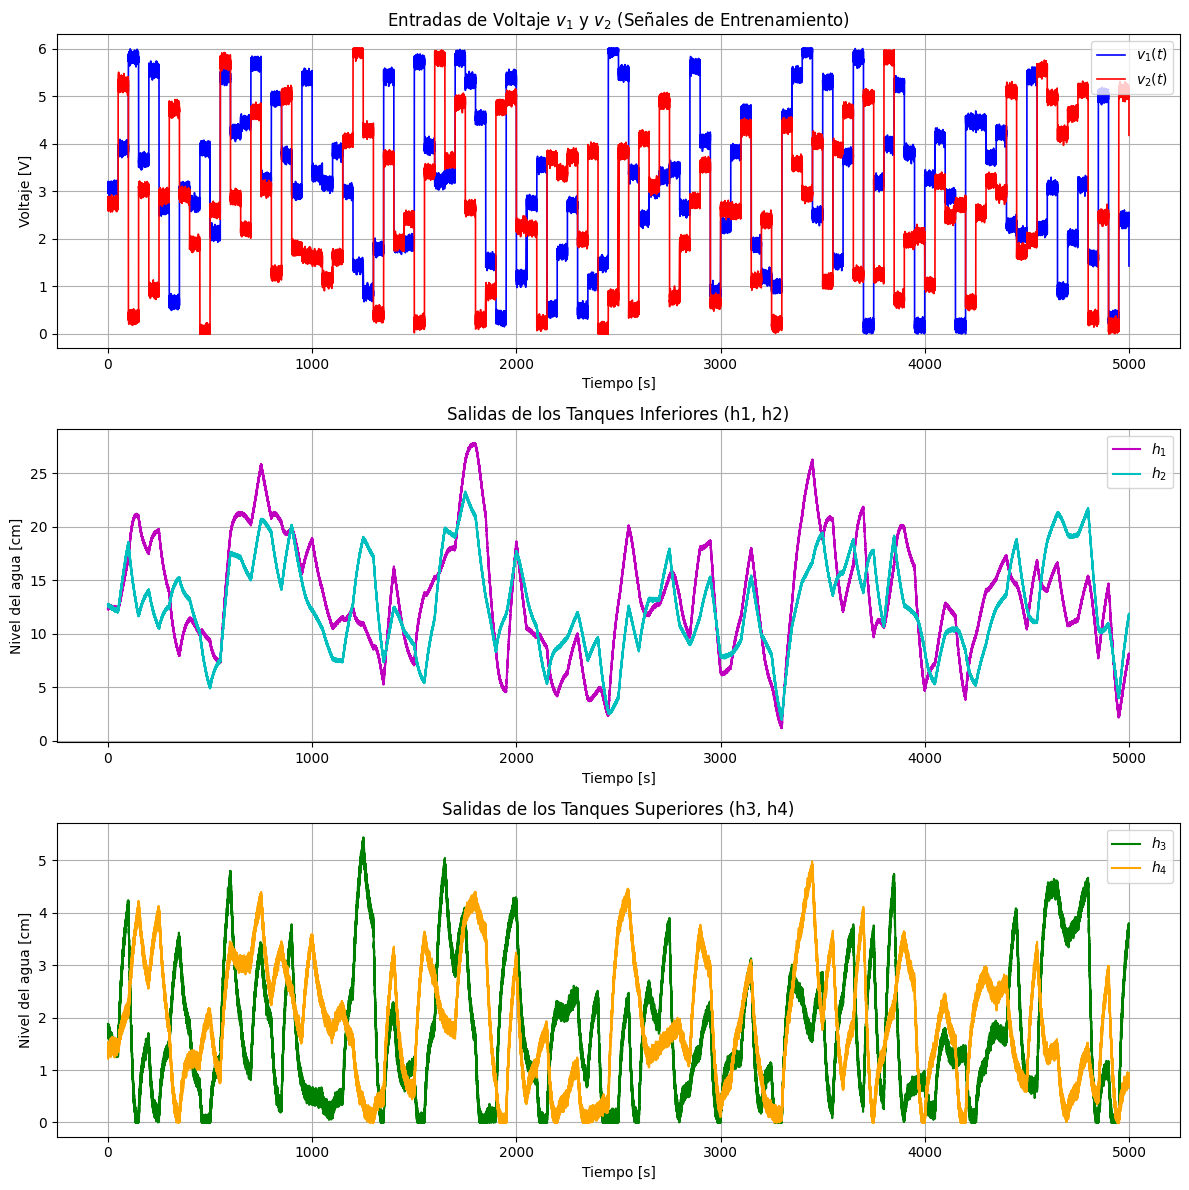

In [58]:
# Figura para visualizar las señales de entrada y salida del sistema.
plt.figure(figsize=(12, 12))

# Subgráfica 1: Señales de entrada de control (Voltajes de las bombas v1 y v2)
plt.subplot(3, 1, 1)
plt.plot(t_full, u_full[:, 0], 'b', linewidth=1.2, label='$v_1(t)$')
plt.plot(t_full, u_full[:, 1], 'r', linewidth=1.2, label='$v_2(t)$')
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje [V]')
plt.title('Entradas de Voltaje $v_1$ y $v_2$ (Señales de Entrenamiento)')
plt.legend(loc='upper right')
plt.grid(True)

# Subgráfica 2: Niveles de los tanques inferiores (h1 y h2)
plt.subplot(3, 1, 2)
plt.plot(t_full, h1_full, 'm', linewidth=1.5, label='$h_1$')
plt.plot(t_full, h2_full, 'c', linewidth=1.5, label='$h_2$')
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel del agua [cm]')
plt.title('Salidas de los Tanques Inferiores (h1, h2)')
plt.legend(loc='upper right')
plt.grid(True)

# Subgráfica 3: Niveles de los tanques superiores (h3 y h4)
plt.subplot(3, 1, 3)
plt.plot(t_full, h3_full, 'g', linewidth=1.5, label='$h_3$')
plt.plot(t_full, h4_full, 'orange', linewidth=1.5, label='$h_4$')
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel del agua [cm]')
plt.title('Salidas de los Tanques Superiores (h3, h4)')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## Preprocesamiento, normalización y división de datos

In [59]:
# 1. Entradas: Usamos los datos originales (sin suavizar)
# h1_full, h2_full, etc., deben ser tus vectores de datos crudos
X_train = np.hstack([
    h1_full[:-1, None],
    h2_full[:-1, None],
    h3_full[:-1, None],
    h4_full[:-1, None],
    u_full[:-1, :]
])

# 2. Salidas: Estado siguiente original
Y_train = np.hstack([
    h1_full[1:, None],
    h2_full[1:, None],
    h3_full[1:, None],
    h4_full[1:, None]
])

## Arquitectura de red neuronal para entrenamiento

In [60]:
# Dimensiones del sistema MIMO
INPUT_SIZE = 6   # [h1(k), h2(k), h3(k), h4(k), v1(k), v2(k)]
OUTPUT_SIZE = 4  # [h1(k+1), h2(k+1), h3(k+1), h4(k+1)]
HIDDEN_LAYERS = 4
HIDDEN_NEURONS = 48

class PINN_StateSpace_SiLU(nn.Module):
    def __init__(self, input_size, output_size, num_layers, num_neurons):
        super(PINN_StateSpace_SiLU, self).__init__()

        layers = []

        # Capa de entrada: Procesa estados y controles simultáneamente
        layers.append(nn.Linear(input_size, num_neurons))
        layers.append(nn.SiLU())

        # Capas ocultas: Capturan el acoplamiento entre los 4 tanques
        for _ in range(num_layers):
            layers.append(nn.Linear(num_neurons, num_neurons))
            layers.append(nn.SiLU())

        # Capa de salida: Predicción de los 4 estados en k+1
        layers.append(nn.Linear(num_neurons, output_size))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Determinar el dispositivo de cómputo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instancia del modelo adaptado al sistema de 4 tanques
model = PINN_StateSpace_SiLU(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_LAYERS, HIDDEN_NEURONS).to(device)

print(f"Modelo PINN MIMO (4 Tanques) creado. Entradas: {INPUT_SIZE}, Salidas: {OUTPUT_SIZE}")
print(f"Dispositivo actual: {device}")

Modelo PINN MIMO (4 Tanques) creado. Entradas: 6, Salidas: 4
Dispositivo actual: cuda


## Funciones de normalización y denormalización

In [61]:
#Normalización Min-Max
def normalize_data(data, data_min, data_max):
    denom = data_max - data_min
    if denom == 0:
        return data
    return (data - data_min) / denom

#Denormalización inversa
def denormalize_data(data_norm, data_min, data_max):
    return data_norm * (data_max - data_min) + data_min

## Parámetros de escala para entrenamiento

In [62]:
# Estructura de diccionario para almacenar los límites Min/Max de cada variable.
SCALING_PARAMS = {}

# Parámetros para Entradas de Control (u_full contiene v1 y v2)
v1_min, v1_max = X_train[:, 4].min(), X_train[:, 4].max()
v2_min, v2_max = X_train[:, 5].min(), X_train[:, 5].max()

SCALING_PARAMS['v1'] = {'min': v1_min, 'max': v1_max}
SCALING_PARAMS['v2'] = {'min': v2_min, 'max': v2_max}

# Tanque 1
h1_min = min(X_train[:, 0].min(), Y_train[:, 0].min())
h1_max = max(X_train[:, 0].max(), Y_train[:, 0].max())
SCALING_PARAMS['h1'] = {'min': h1_min, 'max': h1_max}

# Tanque 2
h2_min = min(X_train[:, 1].min(), Y_train[:, 1].min())
h2_max = max(X_train[:, 1].max(), Y_train[:, 1].max())
SCALING_PARAMS['h2'] = {'min': h2_min, 'max': h2_max}

# Tanque 3
h3_min = min(X_train[:, 2].min(), Y_train[:, 2].min())
h3_max = max(X_train[:, 2].max(), Y_train[:, 2].max())
SCALING_PARAMS['h3'] = {'min': h3_min, 'max': h3_max}

# Tanque 4
h4_min = min(X_train[:, 3].min(), Y_train[:, 3].min())
h4_max = max(X_train[:, 3].max(), Y_train[:, 3].max())
SCALING_PARAMS['h4'] = {'min': h4_min, 'max': h4_max}

print("Parámetros de escala definidos para el modelo MIMO [h1, h2, h3, h4, v1, v2].")

Parámetros de escala definidos para el modelo MIMO [h1, h2, h3, h4, v1, v2].


## Normalización de datos de entrada y salida para entrenamiento

In [63]:
# Descomposición de X_train (Entradas: h1_k, h2_k, h3_k, h4_k, v1_k, v2_k)
h1_k = X_train[:, 0]
h2_k = X_train[:, 1]
h3_k = X_train[:, 2]
h4_k = X_train[:, 3]
v1_k = X_train[:, 4]
v2_k = X_train[:, 5]

# Descomposición de Y_train (Salidas: h1_k+1, h2_k+1, h3_k+1, h4_k+1)
h1_next = Y_train[:, 0]
h2_next = Y_train[:, 1]
h3_next = Y_train[:, 2]
h4_next = Y_train[:, 3]

# Aplicación de normalización Min-Max a cada variable de entrada
h1_k_norm = normalize_data(h1_k, SCALING_PARAMS['h1']['min'], SCALING_PARAMS['h1']['max'])
h2_k_norm = normalize_data(h2_k, SCALING_PARAMS['h2']['min'], SCALING_PARAMS['h2']['max'])
h3_k_norm = normalize_data(h3_k, SCALING_PARAMS['h3']['min'], SCALING_PARAMS['h3']['max'])
h4_k_norm = normalize_data(h4_k, SCALING_PARAMS['h4']['min'], SCALING_PARAMS['h4']['max'])
v1_k_norm = normalize_data(v1_k, SCALING_PARAMS['v1']['min'], SCALING_PARAMS['v1']['max'])
v2_k_norm = normalize_data(v2_k, SCALING_PARAMS['v2']['min'], SCALING_PARAMS['v2']['max'])

# Aplicación de normalización Min-Max a cada variable de salida (k+1)
h1_next_norm = normalize_data(h1_next, SCALING_PARAMS['h1']['min'], SCALING_PARAMS['h1']['max'])
h2_next_norm = normalize_data(h2_next, SCALING_PARAMS['h2']['min'], SCALING_PARAMS['h2']['max'])
h3_next_norm = normalize_data(h3_next, SCALING_PARAMS['h3']['min'], SCALING_PARAMS['h3']['max'])
h4_next_norm = normalize_data(h4_next, SCALING_PARAMS['h4']['min'], SCALING_PARAMS['h4']['max'])

# Reensamblar los conjuntos de datos normalizados para el entrenamiento
X_train_norm = np.hstack([
    h1_k_norm[:, None],
    h2_k_norm[:, None],
    h3_k_norm[:, None],
    h4_k_norm[:, None],
    v1_k_norm[:, None],
    v2_k_norm[:, None]
])

Y_train_norm = np.hstack([
    h1_next_norm[:, None],
    h2_next_norm[:, None],
    h3_next_norm[:, None],
    h4_next_norm[:, None]
])

print("Normalización aplicada exitosamente a la estructura MIMO de 4 tanques.")
print(f"Dimensiones finales: X_train_norm {X_train_norm.shape}, Y_train_norm {Y_train_norm.shape}")

Normalización aplicada exitosamente a la estructura MIMO de 4 tanques.
Dimensiones finales: X_train_norm (100000, 6), Y_train_norm (100000, 4)


## Tensores de entrenamiento

In [64]:
# Tensores de Entrenamiento (Observaciones para Loss de Datos)
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train_norm, dtype=torch.float32).to(device)


''' En el modelo de espacio de estados, se usa los mismos puntos de entrada
para evaluar la pérdida física (residual de la EDO). requires_grad_(True) es
vital para que la PINN pueda derivar respecto a los estados de entrada.'''

X_physics_tensor = X_train_tensor.clone().detach().requires_grad_(True)

print(f"\nConversión a tensores de PyTorch completada en el dispositivo: {device}")
print(f"X_train_tensor.shape (Data Loss - MIMO 6): {X_train_tensor.shape}")
print(f"Y_train_tensor.shape (Data Loss - MIMO 4): {Y_train_tensor.shape}")
print(f"X_physics_tensor.shape (Physics Loss - MIMO 6): {X_physics_tensor.shape}")


Conversión a tensores de PyTorch completada en el dispositivo: cuda
X_train_tensor.shape (Data Loss - MIMO 6): torch.Size([100000, 6])
Y_train_tensor.shape (Data Loss - MIMO 4): torch.Size([100000, 4])
X_physics_tensor.shape (Physics Loss - MIMO 6): torch.Size([100000, 6])


## Función de pérdida física para la red neuronal informada por físicas

In [65]:
class PhysicsLoss(nn.Module):
    def __init__(self, A1, A2, A3, A4, a1, a2, a3, a4, g, k1, k2, gamma1, gamma2, epsilon, dt, SCALING_PARAMS):
        super(PhysicsLoss, self).__init__()

        # Almacenar constantes físicas como tensores
        self.A1, self.A2 = torch.tensor(A1).to(device), torch.tensor(A2).to(device)
        self.A3, self.A4 = torch.tensor(A3).to(device), torch.tensor(A4).to(device)
        self.a1, self.a2 = torch.tensor(a1).to(device), torch.tensor(a2).to(device)
        self.a3, self.a4 = torch.tensor(a3).to(device), torch.tensor(a4).to(device)
        self.g = torch.tensor(g).to(device)
        self.k1, self.k2 = torch.tensor(k1).to(device), torch.tensor(k2).to(device)
        self.gamma1 = torch.tensor(gamma1).to(device)
        self.gamma2 = torch.tensor(gamma2).to(device)

        self.epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)
        self.dt = torch.tensor(dt, dtype=torch.float32).to(device)

        # Parámetros de denormalización (4 tanques + 2 bombas)
        self.h1_min, self.h1_max = torch.tensor(SCALING_PARAMS['h1']['min']).to(device), torch.tensor(SCALING_PARAMS['h1']['max']).to(device)
        self.h2_min, self.h2_max = torch.tensor(SCALING_PARAMS['h2']['min']).to(device), torch.tensor(SCALING_PARAMS['h2']['max']).to(device)
        self.h3_min, self.h3_max = torch.tensor(SCALING_PARAMS['h3']['min']).to(device), torch.tensor(SCALING_PARAMS['h3']['max']).to(device)
        self.h4_min, self.h4_max = torch.tensor(SCALING_PARAMS['h4']['min']).to(device), torch.tensor(SCALING_PARAMS['h4']['max']).to(device)
        self.v1_min, self.v1_max = torch.tensor(SCALING_PARAMS['v1']['min']).to(device), torch.tensor(SCALING_PARAMS['v1']['max']).to(device)
        self.v2_min, self.v2_max = torch.tensor(SCALING_PARAMS['v2']['min']).to(device), torch.tensor(SCALING_PARAMS['v2']['max']).to(device)

    def forward(self, x_norm, h_next_pred_norm):
        # 1. Denormalización del estado actual k (Entradas)
        h1_k = self.h1_min + x_norm[:, 0:1] * (self.h1_max - self.h1_min)
        h2_k = self.h2_min + x_norm[:, 1:2] * (self.h2_max - self.h2_min)
        h3_k = self.h3_min + x_norm[:, 2:3] * (self.h3_max - self.h3_min)
        h4_k = self.h4_min + x_norm[:, 3:4] * (self.h4_max - self.h4_min)
        v1_k = self.v1_min + x_norm[:, 4:5] * (self.v1_max - self.v1_min)
        v2_k = self.v2_min + x_norm[:, 5:6] * (self.v2_max - self.v2_min)

        # 2. Denormalización del estado predicho k+1 (Salidas de la red)
        h1_k1_pred = self.h1_min + h_next_pred_norm[:, 0:1] * (self.h1_max - self.h1_min)
        h2_k1_pred = self.h2_min + h_next_pred_norm[:, 1:2] * (self.h2_max - self.h2_min)
        h3_k1_pred = self.h3_min + h_next_pred_norm[:, 2:3] * (self.h3_max - self.h3_min)
        h4_k1_pred = self.h4_min + h_next_pred_norm[:, 3:4] * (self.h4_max - self.h4_min)

        # 3. Cálculo de las derivadas físicas instantáneas (Leyes de Torricelli y Balance de Masa)
        h1_s = torch.max(h1_k, self.epsilon)
        h2_s = torch.max(h2_k, self.epsilon)
        h3_s = torch.max(h3_k, self.epsilon)
        h4_s = torch.max(h4_k, self.epsilon)

        dh1_dt = -(self.a1/self.A1)*torch.sqrt(2*self.g*h1_s) + (self.a3/self.A1)*torch.sqrt(2*self.g*h3_s) + (self.gamma1*self.k1/self.A1)*v1_k
        dh2_dt = -(self.a2/self.A2)*torch.sqrt(2*self.g*h2_s) + (self.a4/self.A2)*torch.sqrt(2*self.g*h4_s) + (self.gamma2*self.k2/self.A2)*v2_k
        dh3_dt = -(self.a3/self.A3)*torch.sqrt(2*self.g*h3_s) + ((1-self.gamma2)*self.k2/self.A3)*v2_k
        dh4_dt = -(self.a4/self.A4)*torch.sqrt(2*self.g*h4_s) + ((1-self.gamma1)*self.k1/self.A4)*v1_k

        # 4. Cálculo de los residuales basados en Euler
        R1 = h1_k1_pred - (h1_k + self.dt * dh1_dt)
        R2 = h2_k1_pred - (h2_k + self.dt * dh2_dt)
        R3 = h3_k1_pred - (h3_k + self.dt * dh3_dt)
        R4 = h4_k1_pred - (h4_k + self.dt * dh4_dt)

        return R1, R2, R3, R4

## Función de cálculo total de la pérdida de la red neuronal

In [66]:
def calculate_total_loss(model, physics_loss_module, X_train, Y_train, X_res, w_data=1.0, w_res=200.0, w_ic=10.0):
    # 1. Pérdida de los datos (Supervisada - Mean Squared Error)
    h_pred_data = model(X_train)
    loss_data = torch.mean((h_pred_data - Y_train) ** 2)

    # 2. Pérdida residual (Física / PINN)
    h_pred_res = model(X_res)

    # Residuales del sistema MIMO
    R1, R2, R3, R4 = physics_loss_module(X_res, h_pred_res)

    # Sumatoria de los residuales físicos al cuadrado
    loss_res = torch.mean(R1 ** 2) + torch.mean(R2 ** 2) + \
               torch.mean(R3 ** 2) + torch.mean(R4 ** 2)

    # 3. Pérdida de condiciones iniciales (IC)
    X_ic = X_train[0:1]
    h_pred_ic = model(X_ic)
    Y_ic_target = Y_train[0:1]
    loss_ic = torch.mean((h_pred_ic - Y_ic_target) ** 2)

    # 4. Pérdida total ponderada
    total_loss = w_data * loss_data + w_res * loss_res + w_ic * loss_ic

    return total_loss, loss_data, loss_res, loss_ic

## Inicialización de pérdida física e historial de entrenamiento

In [67]:
# Parámetro de estabilidad para evitar gradientes infinitos en sqrt(h)
epsilon = 1e-6

# Mover el modelo de red neuronal al dispositivo de cómputo (GPU/CPU)
model.to(device)

# Inicializar el módulo de pérdida física con los parámetros del sistema MIMO
physics_loss_module = PhysicsLoss(
    A1, A2, A3, A4,
    a1, a2, a3, a4,
    g, k1, k2,
    gamma1, gamma2,
    epsilon, dt, SCALING_PARAMS
).to(device)

# Listas de historial para monitorear la convergencia del entrenamiento
loss_history = []
loss_data_history = []
loss_res_history = []
loss_ic_history = []

print("Módulo de pérdida física configurado para el sistema de 4 tanques.")

Módulo de pérdida física configurado para el sistema de 4 tanques.


## Primera fase de entrenamiento con optimizador Adam

In [68]:
# Definición de los pesos para la función de pérdida
W_DATA = 1.0
W_RES = 200.0
W_IC = 10.0

LEARNING_RATE_ADAM = 1e-3
NUM_EPOCHS_ADAM = 4500
optimizer_adam = optim.Adam(model.parameters(), lr=LEARNING_RATE_ADAM)

print(f"--- FASE 1: Iniciando entrenamiento con Adam ({NUM_EPOCHS_ADAM} épocas) ---")
print(f"Entrenando para un sistema de 4 estados y 2 entradas...")

for epoch in range(1, NUM_EPOCHS_ADAM + 1):
    model.train()
    optimizer_adam.zero_grad()

    # Cálculo de la pérdida total utilizando el módulo adaptado a 4 tanques
    # X_train_tensor: [h1_k, h2_k, h3_k, h4_k, v1_k, v2_k]
    # Y_train_tensor: [h1_k+1, h2_k+1, h3_k+1, h4_k+1]
    total_loss, loss_data, loss_res, loss_ic = calculate_total_loss(
        model,
        physics_loss_module,
        X_train_tensor,
        Y_train_tensor,
        X_physics_tensor,
        w_data=W_DATA,
        w_res=W_RES,
        w_ic=W_IC
    )

    # Retropropagación
    total_loss.backward()
    optimizer_adam.step()

    # Monitoreo y almacenamiento de historial cada 250 épocas
    if epoch % 250 == 0:
        loss_history.append(total_loss.item())
        loss_data_history.append(loss_data.item())
        loss_res_history.append(loss_res.item())
        loss_ic_history.append(loss_ic.item())

        # Impresión de progreso: L_D (Pérdida Datos), L_R (Pérdida Residual Física)
        print(f"Adam Época: {epoch}/{NUM_EPOCHS_ADAM} | Total Loss: {total_loss.item():.6e} | L_D: {loss_data.item():.6e} | L_R: {loss_res.item():.6e}")

print("--- FASE 1 COMPLETADA ---")
print(f"Pérdida final de Adam: {total_loss.item():.6e}")

--- FASE 1: Iniciando entrenamiento con Adam (4500 épocas) ---
Entrenando para un sistema de 4 estados y 2 entradas...
Adam Época: 250/4500 | Total Loss: 5.613642e+02 | L_D: 1.003286e-02 | L_R: 2.806740e+00
Adam Época: 500/4500 | Total Loss: 1.352872e+02 | L_D: 4.650286e-03 | L_R: 6.764055e-01
Adam Época: 750/4500 | Total Loss: 1.210654e+02 | L_D: 4.405901e-03 | L_R: 6.052985e-01
Adam Época: 1000/4500 | Total Loss: 2.847092e+01 | L_D: 8.160301e-04 | L_R: 1.423428e-01
Adam Época: 1250/4500 | Total Loss: 1.228938e+01 | L_D: 3.210939e-04 | L_R: 6.144106e-02
Adam Época: 1500/4500 | Total Loss: 7.527687e+00 | L_D: 2.455132e-04 | L_R: 3.763376e-02
Adam Época: 1750/4500 | Total Loss: 5.677611e+00 | L_D: 2.495454e-04 | L_R: 2.838245e-02
Adam Época: 2000/4500 | Total Loss: 4.888840e+00 | L_D: 2.524242e-04 | L_R: 2.443815e-02
Adam Época: 2250/4500 | Total Loss: 4.464315e+00 | L_D: 2.490490e-04 | L_R: 2.231541e-02
Adam Época: 2500/4500 | Total Loss: 4.137099e+00 | L_D: 2.422077e-04 | L_R: 2.06793

## Segunda fase de entrenamiento con optimizador L-BFGS

In [69]:
# Configuración del optimizador L-BFGS
optimizer_lbfgs = optim.LBFGS(
    model.parameters(),
    lr=0.5,
    max_iter=4000,
    max_eval=4000,
    history_size=50,
    tolerance_grad=1e-9,
    tolerance_change=1e-11,
    line_search_fn="strong_wolfe" # Búsqueda de línea para garantizar descenso
)

lbfgs_eval_count = 0
current_lbfgs_loss = 0.0

def closure():
    global lbfgs_eval_count, current_lbfgs_loss
    lbfgs_eval_count += 1
    optimizer_lbfgs.zero_grad()

    # Cálculo de pérdida con la estructura MIMO de 4 tanques
    # X_train_tensor: Datos observados [h1...h4, v1, v2]
    # X_physics_tensor: Puntos para validar las 4 ecuaciones diferenciales
    total_loss, loss_data, loss_res, loss_ic = calculate_total_loss(
        model,
        physics_loss_module,
        X_train_tensor,
        Y_train_tensor,
        X_physics_tensor,
        w_data=W_DATA,
        w_res=W_RES,
        w_ic=W_IC
    )

    # Retropropagación
    total_loss.backward()

    # Monitoreo de la pérdida actual
    current_lbfgs_loss = total_loss.item()

    if lbfgs_eval_count % 100 == 0:
        print(f"L-BFGS Evaluación: {lbfgs_eval_count} | Loss: {total_loss.item():.6e} | Res: {loss_res.item():.6e}")

    return total_loss

print("\n--- FASE 2: Iniciando ajuste fino con L-BFGS-B (Alta Precisión) ---")
print("Este proceso busca el mínimo global de los 4 residuales físicos...")
optimizer_lbfgs.step(closure)

print("\n--- FASE 2 COMPLETADA ---")
print(f"L-BFGS ha finalizado el ajuste. Pérdida final consolidada: {current_lbfgs_loss:.6e}")


--- FASE 2: Iniciando ajuste fino con L-BFGS-B (Alta Precisión) ---
Este proceso busca el mínimo global de los 4 residuales físicos...
L-BFGS Evaluación: 100 | Loss: 7.885597e-01 | Res: 3.941359e-03
L-BFGS Evaluación: 200 | Loss: 3.053763e-01 | Res: 1.525490e-03
L-BFGS Evaluación: 300 | Loss: 1.784512e-01 | Res: 8.907417e-04
L-BFGS Evaluación: 400 | Loss: 1.282445e-01 | Res: 6.399426e-04
L-BFGS Evaluación: 500 | Loss: 1.054001e-01 | Res: 5.256968e-04
L-BFGS Evaluación: 600 | Loss: 8.539770e-02 | Res: 4.255763e-04
L-BFGS Evaluación: 700 | Loss: 6.613078e-02 | Res: 3.294287e-04
L-BFGS Evaluación: 800 | Loss: 5.518355e-02 | Res: 2.747380e-04
L-BFGS Evaluación: 900 | Loss: 4.598794e-02 | Res: 2.286792e-04
L-BFGS Evaluación: 1000 | Loss: 3.876172e-02 | Res: 1.926122e-04
L-BFGS Evaluación: 1100 | Loss: 3.439085e-02 | Res: 1.707868e-04
L-BFGS Evaluación: 1200 | Loss: 2.984196e-02 | Res: 1.480265e-04
L-BFGS Evaluación: 1300 | Loss: 2.775312e-02 | Res: 1.375900e-04
L-BFGS Evaluación: 1400 | Lo

## Denormalización de predicción y datos reales después de entrenamiento

In [70]:
# Evaluación del modelo
model.eval()

with torch.no_grad():

    '''La red predice el vector de estados k+1: [h1, h2, h3, h4] a
    partir de X_train_tensor: [h1_k, h2_k, h3_k, h4_k, v1_k, v2_k]'''

    h_pred_train_norm = model(X_train_tensor).cpu().numpy()

# Denormalización de las 4 predicciones del modelo (Salidas k+1)
h1_pred_train = denormalize_data(h_pred_train_norm[:, 0], SCALING_PARAMS['h1']['min'], SCALING_PARAMS['h1']['max'])
h2_pred_train = denormalize_data(h_pred_train_norm[:, 1], SCALING_PARAMS['h2']['min'], SCALING_PARAMS['h2']['max'])
h3_pred_train = denormalize_data(h_pred_train_norm[:, 2], SCALING_PARAMS['h3']['min'], SCALING_PARAMS['h3']['max'])
h4_pred_train = denormalize_data(h_pred_train_norm[:, 3], SCALING_PARAMS['h4']['min'], SCALING_PARAMS['h4']['max'])

# Denormalización de los datos reales (Targets k+1 para comparación)
Y_train_real_norm = Y_train_tensor.cpu().numpy()
h1_train_real = denormalize_data(Y_train_real_norm[:, 0], SCALING_PARAMS['h1']['min'], SCALING_PARAMS['h1']['max'])
h2_train_real = denormalize_data(Y_train_real_norm[:, 1], SCALING_PARAMS['h2']['min'], SCALING_PARAMS['h2']['max'])
h3_train_real = denormalize_data(Y_train_real_norm[:, 2], SCALING_PARAMS['h3']['min'], SCALING_PARAMS['h3']['max'])
h4_train_real = denormalize_data(Y_train_real_norm[:, 3], SCALING_PARAMS['h4']['min'], SCALING_PARAMS['h4']['max'])

# Vector de tiempo para la validación (k+1)
t_plot = t_full[1:]

print("Predicciones denormalizadas para los 4 tanques.")

Predicciones denormalizadas para los 4 tanques.


## Visualización de tanques 1 y 2: Red neuronal informada por físicas vs Simulación

In [71]:
def calculate_metrics(real, pred):
    # Root Mean Square Error
    rmse = np.sqrt(np.mean((real - pred)**2))
    # Variance Actually Fraction
    vaf = max(0, (1 - np.var(real - pred) / np.var(real)) * 100)
    return rmse, vaf

# Calcular métricas para h1 y h2
rmse1, vaf1 = calculate_metrics(h1_train_real, h1_pred_train)
rmse2, vaf2 = calculate_metrics(h2_train_real, h2_pred_train)
rmse3, vaf3 = calculate_metrics(h3_train_real, h3_pred_train)
rmse4, vaf4 = calculate_metrics(h4_train_real, h4_pred_train)

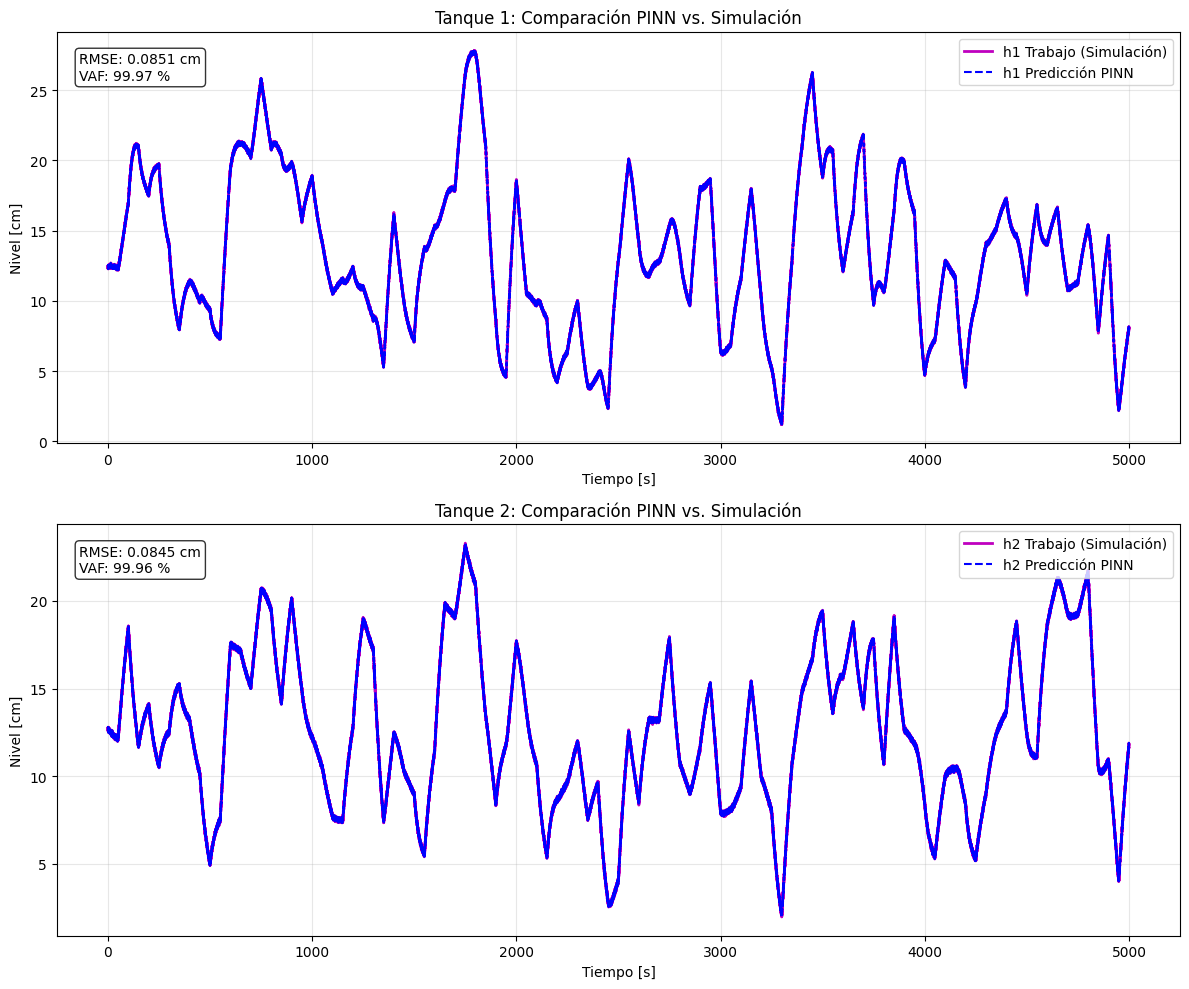

Métricas Finales:
Tanque 1 -> RMSE: 0.0851, VAF: 99.97%
Tanque 2 -> RMSE: 0.0845, VAF: 99.96%


In [72]:
# Figura de visualización
plt.figure(figsize=(12, 10))

# Altura h1 (Tanque Inferior 1)
plt.subplot(2, 1, 1)
plt.plot(t_plot, h1_train_real, 'm', linewidth=2, label='h1 Trabajo (Simulación)')
plt.plot(t_plot, h1_pred_train, 'b--', linewidth=1.5, label='h1 Predicción PINN')
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel [cm]')
plt.title('Tanque 1: Comparación PINN vs. Simulación')
# Añadir métricas en el gráfico
textstr1 = '\n'.join((f'RMSE: {rmse1:.4f} cm', f'VAF: {vaf1:.2f} %'))
plt.gca().text(0.02, 0.95, textstr1, transform=plt.gca().transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Altura h2 (Tanque Inferior 2)
plt.subplot(2, 1, 2)
plt.plot(t_plot, h2_train_real, 'm', linewidth=2, label='h2 Trabajo (Simulación)')
plt.plot(t_plot, h2_pred_train, 'b--', linewidth=1.5, label='h2 Predicción PINN')
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel [cm]')
plt.title('Tanque 2: Comparación PINN vs. Simulación')
# Añadir métricas en el gráfico
textstr2 = '\n'.join((f'RMSE: {rmse2:.4f} cm', f'VAF: {vaf2:.2f} %'))
plt.gca().text(0.02, 0.95, textstr2, transform=plt.gca().transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Métricas Finales:\nTanque 1 -> RMSE: {rmse1:.4f}, VAF: {vaf1:.2f}%")
print(f"Tanque 2 -> RMSE: {rmse2:.4f}, VAF: {vaf2:.2f}%")

In [106]:
import pandas as pd

# 1. Preparación de los datos de series temporales
# Aseguramos que t_plot, h1_train_real, etc., sean arreglos 1D
data_pinn_inferiores = {
    'Tiempo [s]': t_plot.flatten(),
    'h1_Real [cm]': h1_train_real.flatten(),
    'h1_PINN [cm]': h1_pred_train.flatten(),
    'h2_Real [cm]': h2_train_real.flatten(),
    'h2_PINN [cm]': h2_pred_train.flatten()
}

# 2. Creación y guardado del DataFrame de datos
df_pinn_inf = pd.DataFrame(data_pinn_inferiores)
df_pinn_inf.to_csv('comparacion_pinn_tanques_inferiores.csv', index=False)

# 3. Guardado de las métricas de desempeño (RMSE y VAF)
metrics_pinn_inf = pd.DataFrame([
    {'Tanque': 'h1', 'RMSE': rmse1, 'VAF': vaf1},
    {'Tanque': 'h2', 'RMSE': rmse2, 'VAF': vaf2}
])
metrics_pinn_inf.to_csv('metricas_pinn_tanques_inferiores.csv', index=False)

print("✅ Datos de PINN (Tanques Inferiores) guardados en 'comparacion_pinn_tanques_inferiores.csv'")
print("📊 Métricas guardadas en 'metricas_pinn_tanques_inferiores.csv'")

✅ Datos de PINN (Tanques Inferiores) guardados en 'comparacion_pinn_tanques_inferiores.csv'
📊 Métricas guardadas en 'metricas_pinn_tanques_inferiores.csv'


## Visualización de tanques 3 y 4: Red neuronal informada por físicas vs Simulación

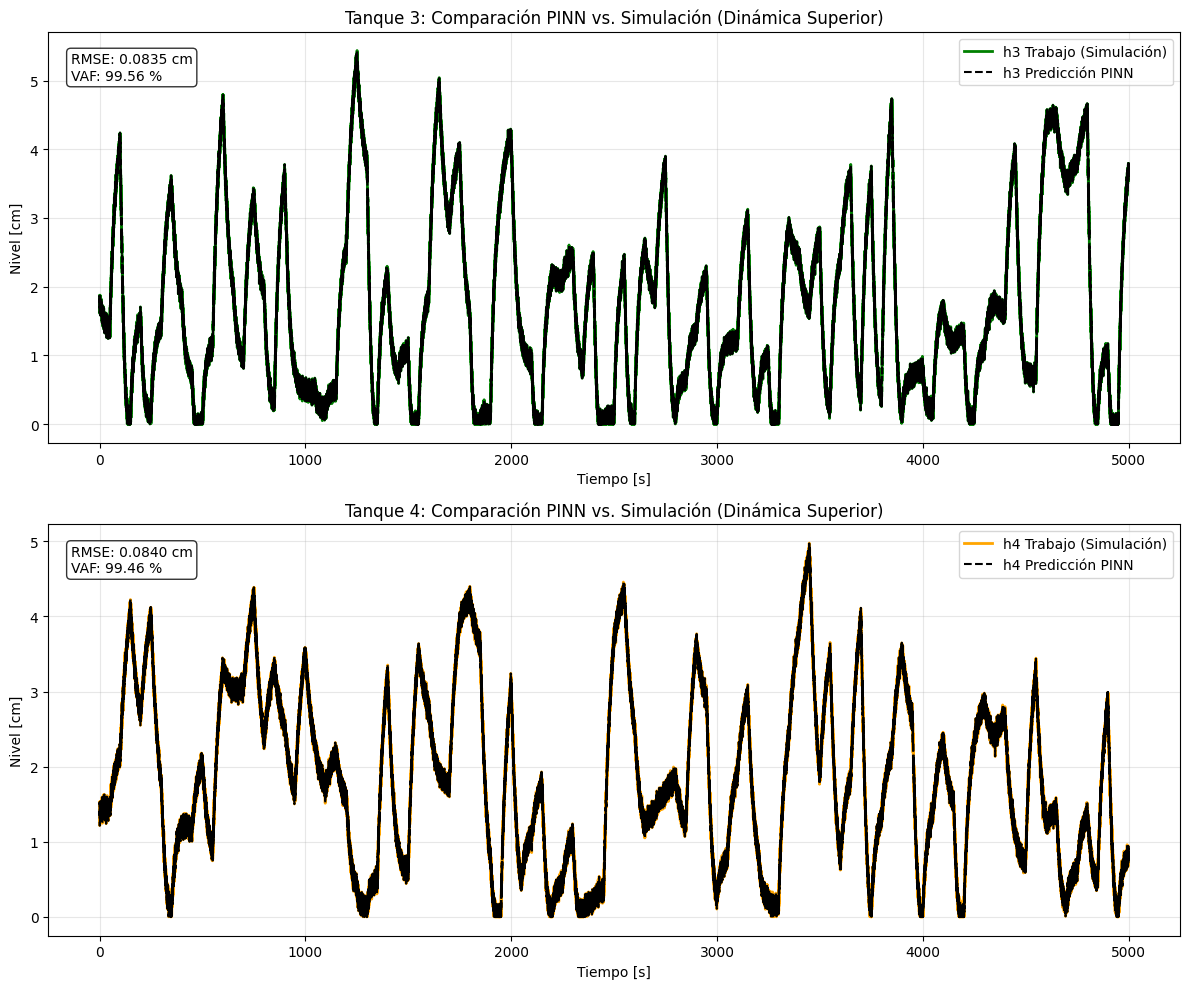

Métricas Finales Superiores:
Tanque 3 -> RMSE: 0.0835, VAF: 99.56%
Tanque 4 -> RMSE: 0.0840, VAF: 99.46%


In [73]:
# Figura de visualización para Tanques Superiores
plt.figure(figsize=(12, 10))

# Altura h3 (Tanque Superior 3)
plt.subplot(2, 1, 1)
plt.plot(t_plot, h3_train_real, 'g', linewidth=2, label='h3 Trabajo (Simulación)')
plt.plot(t_plot, h3_pred_train, 'k--', linewidth=1.5, label='h3 Predicción PINN')
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel [cm]')
plt.title('Tanque 3: Comparación PINN vs. Simulación (Dinámica Superior)')

# Añadir métricas h3
textstr3 = '\n'.join((f'RMSE: {rmse3:.4f} cm', f'VAF: {vaf3:.2f} %'))
plt.gca().text(0.02, 0.95, textstr3, transform=plt.gca().transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Altura h4 (Tanque Superior 4)
plt.subplot(2, 1, 2)
plt.plot(t_plot, h4_train_real, 'orange', linewidth=2, label='h4 Trabajo (Simulación)')
plt.plot(t_plot, h4_pred_train, 'k--', linewidth=1.5, label='h4 Predicción PINN')
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel [cm]')
plt.title('Tanque 4: Comparación PINN vs. Simulación (Dinámica Superior)')

# Añadir métricas h4
textstr4 = '\n'.join((f'RMSE: {rmse4:.4f} cm', f'VAF: {vaf4:.2f} %'))
plt.gca().text(0.02, 0.95, textstr4, transform=plt.gca().transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Métricas Finales Superiores:\nTanque 3 -> RMSE: {rmse3:.4f}, VAF: {vaf3:.2f}%")
print(f"Tanque 4 -> RMSE: {rmse4:.4f}, VAF: {vaf4:.2f}%")

In [107]:
import pandas as pd

# 1. Consolidación de datos de series temporales (Tanques Superiores)
# Aseguramos que todos los vectores sean 1D usando .flatten()
data_pinn_superiores = {
    'Tiempo [s]': t_plot.flatten(),
    'h3_Real [cm]': h3_train_real.flatten(),
    'h3_PINN [cm]': h3_pred_train.flatten(),
    'h4_Real [cm]': h4_train_real.flatten(),
    'h4_PINN [cm]': h4_pred_train.flatten()
}

# 2. Creación del DataFrame y exportación a CSV
df_pinn_sup = pd.DataFrame(data_pinn_superiores)
df_pinn_sup.to_csv('comparacion_pinn_tanques_superiores.csv', index=False)

# 3. Exportación de métricas de desempeño para el reporte
metrics_pinn_sup = pd.DataFrame([
    {'Tanque': 'h3', 'RMSE': rmse3, 'VAF': vaf3},
    {'Tanque': 'h4', 'RMSE': rmse4, 'VAF': vaf4}
])
metrics_pinn_sup.to_csv('metricas_pinn_tanques_superiores.csv', index=False)

print("✅ Archivo 'comparacion_pinn_tanques_superiores.csv' generado con éxito.")
print("📊 Métricas de dinámica superior guardadas en 'metricas_pinn_tanques_superiores.csv'")

✅ Archivo 'comparacion_pinn_tanques_superiores.csv' generado con éxito.
📊 Métricas de dinámica superior guardadas en 'metricas_pinn_tanques_superiores.csv'


## Visualización de pérdidas después de entrenamiento

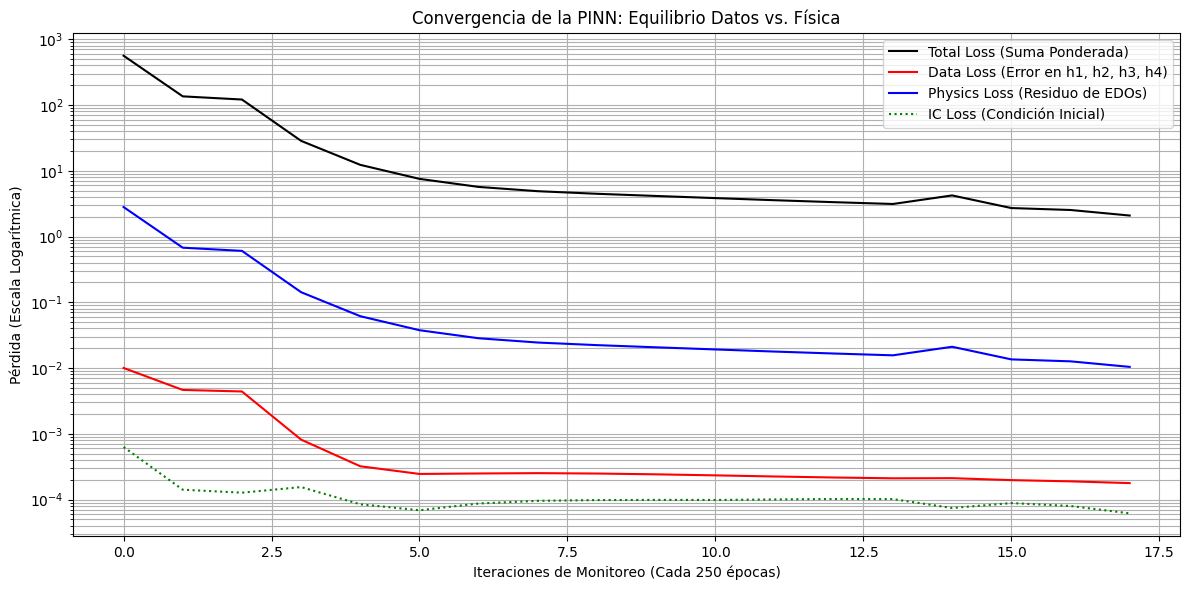

In [74]:
# Figura de visualización de pérdidas
plt.figure(figsize=(12, 6))

plt.semilogy(loss_history, 'k', label='Total Loss (Suma Ponderada)')
plt.semilogy(loss_data_history, 'r', label='Data Loss (Error en h1, h2, h3, h4)')
plt.semilogy(loss_res_history, 'b', label='Physics Loss (Residuo de EDOs)')
plt.semilogy(loss_ic_history, 'g', linestyle=':', label='IC Loss (Condición Inicial)')

plt.xlabel('Iteraciones de Monitoreo (Cada 250 épocas)')
plt.ylabel('Pérdida (Escala Logarítmica)')
plt.title('Convergencia de la PINN: Equilibrio Datos vs. Física')
plt.legend()
plt.grid(True, which="both", ls="-")

plt.tight_layout()
plt.show()

## Gráficas de error de los 4 tanques

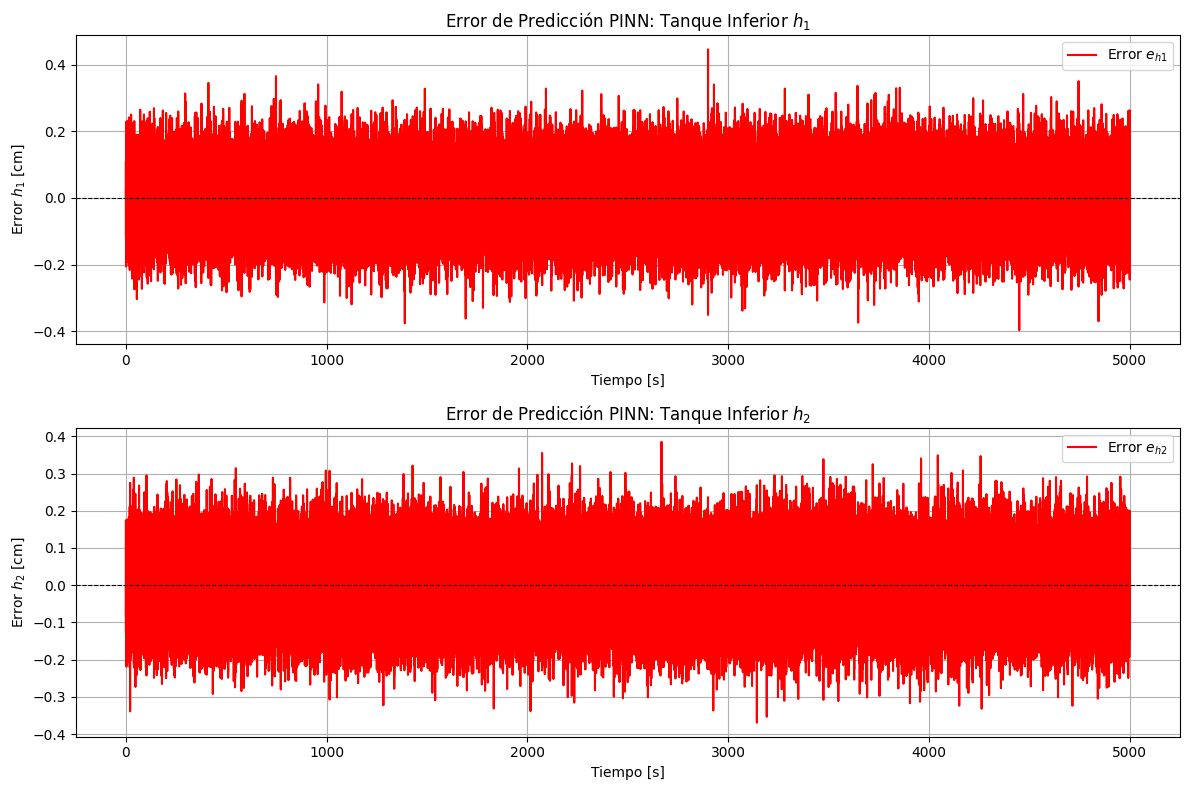

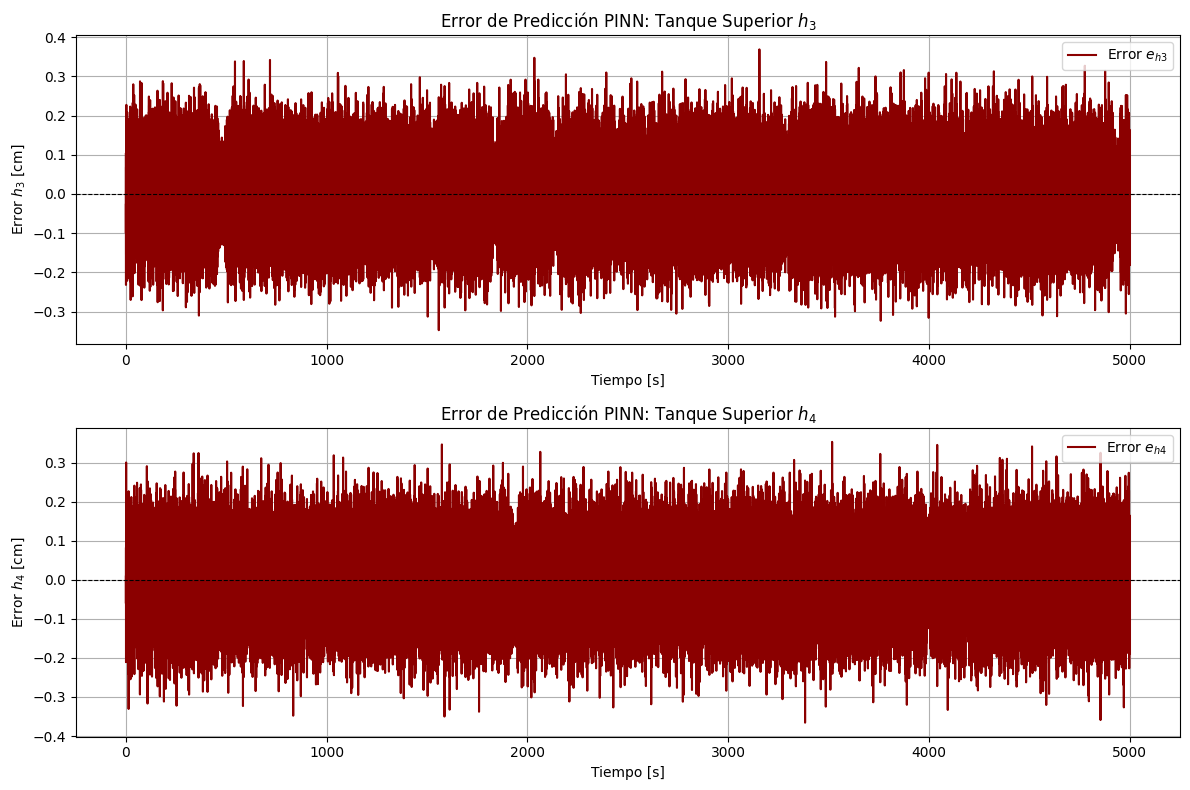

In [75]:
# Cálculo del vector de error para los 4 tanques (Valores en cm)
error_h1_pinn = h1_train_real - h1_pred_train
error_h2_pinn = h2_train_real - h2_pred_train
error_h3_pinn = h3_train_real - h3_pred_train
error_h4_pinn = h4_train_real - h4_pred_train

# Figura de visualización de errores en tanques inferiores
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t_plot, error_h1_pinn, 'r', linewidth=1.5, label='Error $e_{h1}$')
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel('Tiempo [s]')
plt.ylabel('Error $h_1$ [cm]')
plt.title('Error de Predicción PINN: Tanque Inferior $h_1$')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t_plot, error_h2_pinn, 'r', linewidth=1.5, label='Error $e_{h2}$')
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel('Tiempo [s]')
plt.ylabel('Error $h_2$ [cm]')
plt.title('Error de Predicción PINN: Tanque Inferior $h_2$')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Figura de visualización de errores en tanques superiores
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t_plot, error_h3_pinn, 'darkred', linewidth=1.5, label='Error $e_{h3}$')
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel('Tiempo [s]')
plt.ylabel('Error $h_3$ [cm]')
plt.title('Error de Predicción PINN: Tanque Superior $h_3$')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t_plot, error_h4_pinn, 'darkred', linewidth=1.5, label='Error $e_{h4}$')
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel('Tiempo [s]')
plt.ylabel('Error $h_4$ [cm]')
plt.title('Error de Predicción PINN: Tanque Superior $h_4$')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## Métricas de entrenamiento de la red neuronal informada por físicas

In [76]:
# Concatenación de todos los errores (k+1)
error_full = np.concatenate((error_h1_pinn, error_h2_pinn, error_h3_pinn, error_h4_pinn))

MSE = np.mean(error_full**2)
RMSE = np.sqrt(MSE)
MAE = np.mean(np.abs(error_full))
SSE = np.sum(error_full**2)

# Error cuadrático medio normalizado (NRMSE)
h_real_concat = np.concatenate((h1_train_real, h2_train_real, h3_train_real, h4_train_real))
range_h = np.max(h_real_concat) - np.min(h_real_concat)

if range_h != 0:
    NRMSE = RMSE / range_h
else:
    NRMSE = 0.0

print("\n--------------------------- Métricas de Error de Aproximación -------------------------------")
print(f"MSE (Error Cuadrático Medio global)\t\t: {MSE:.8e} m^2 \t|({MSE*10000:.8e} cm^2)")
print(f"RMSE (Raíz del Error Cuadrático Medio global)\t: {RMSE:.8e} m \t|({RMSE*100:.8e} cm)")
print(f"MAE (Error Absoluto Medio global)\t\t: {MAE:.8e} m \t|({MAE*100:.8e} cm)")
print(f"SSE (Suma del Error Cuadrático global)\t\t: {SSE:.8e} m^2 \t|({SSE*10000:.8e} cm^2)")
print(f"NRMSE (Error Normalizado global)\t\t: {NRMSE:.8e} \t|(Adimensional)")


--------------------------- Métricas de Error de Aproximación -------------------------------
MSE (Error Cuadrático Medio global)		: 7.10567609e-03 m^2 	|(7.10567609e+01 cm^2)
RMSE (Raíz del Error Cuadrático Medio global)	: 8.42951724e-02 m 	|(8.42951724e+00 cm)
MAE (Error Absoluto Medio global)		: 6.71561043e-02 m 	|(6.71561043e+00 cm)
SSE (Suma del Error Cuadrático global)		: 2.84227044e+03 m^2 	|(2.84227044e+07 cm^2)
NRMSE (Error Normalizado global)		: 3.02937090e-03 	|(Adimensional)


## Histograma de error de predicción

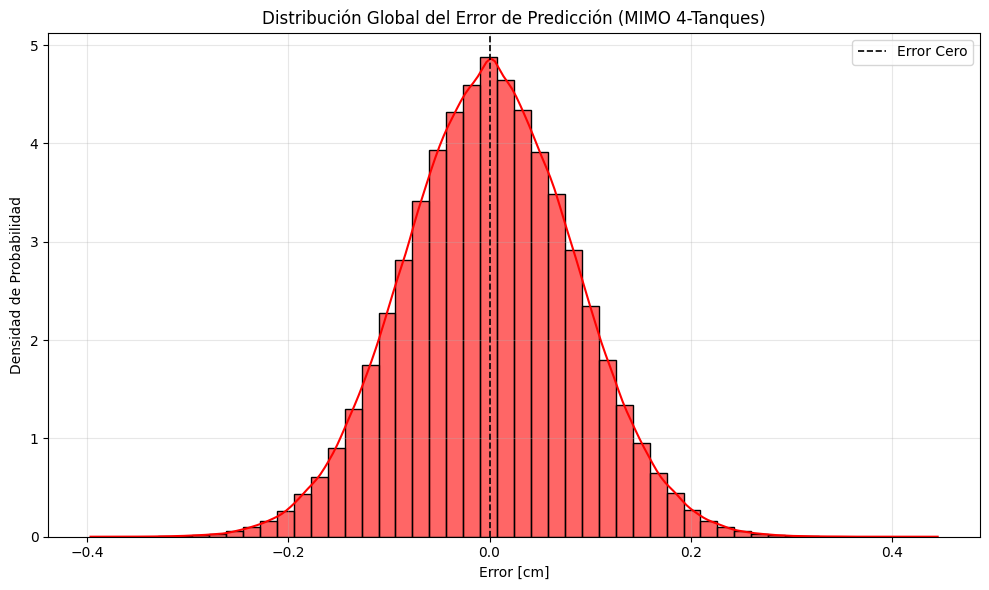

Desviación Estándar del Error: 0.084295 cm
Media del Error (Bias): 0.000018 cm


In [77]:
plt.figure(figsize=(10, 6))

# Distribución del error global (cm)
sns.histplot(error_full, kde=True, color='red', bins=50, stat="density", alpha=0.6)

plt.axvline(x=0, color='black', linestyle='--', linewidth=1.2, label='Error Cero')
plt.title('Distribución Global del Error de Predicción (MIMO 4-Tanques)')
plt.xlabel('Error [cm]')
plt.ylabel('Densidad de Probabilidad')
plt.legend()
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

print(f"Desviación Estándar del Error: {np.std(error_full):.6f} cm")
print(f"Media del Error (Bias): {np.mean(error_full):.6f} cm")

In [78]:
pip install onnx onnxscript onnxruntime

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [79]:
pip install onnxruntime-gpu --user


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [80]:
import torch.onnx

# 1. Asegurar modo evaluación
model.eval()

# 2. Entrada de ejemplo ajustada a tus 6 dimensiones (h1, h2, h3, h4, v1, v2)
# Si tu PINN usa un horizonte o estados previos, ajusta el '6'
dummy_input = torch.randn(1, 6, device=device)

# 3. Exportación robusta
torch.onnx.export(
    model,
    dummy_input,
    "pinn_model.onnx",
    export_params=True,        # Almacena los pesos entrenados dentro del archivo
    opset_version=13,          # Versión estable para la mayoría de los runtimes
    do_constant_folding=True,  # Optimiza el grafo eliminando operaciones constantes
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

print(f"PINN exportada exitosamente a pinn_model.onnx con {dummy_input.shape[1]} features.")

PINN exportada exitosamente a pinn_model.onnx con 6 features.


In [81]:
import onnxruntime as ort
import numpy as np

# --- Configuración de Sesión ---
providers = [
    ('CUDAExecutionProvider', {
        'device_id': 0,
        'arena_extend_strategy': 'kSameAsRequested',
        'gpu_mem_limit': 2 * 1024 * 1024 * 1024,
        'cudnn_conv_algo_search': 'EXHAUSTIVE',
        'do_copy_in_default_stream': True,
    }),
    'CPUExecutionProvider'
]

ort_session = ort.InferenceSession("pinn_model.onnx", providers=providers)
input_name = ort_session.get_inputs()[0].name # Usualmente 'input'

ImportError: DLL load failed while importing onnxruntime_pybind11_state: Error en una rutina de inicialización de biblioteca de vínculos dinámicos (DLL).

## Predicción de horizonte de valores futuros de las alturas de los tanques

In [96]:
def predict_horizon(model, current_h, v_batches, SCALING_PARAMS, device):
    """
    Predice la evolución de los 4 tanques sobre un horizonte N_p.
    Optimizado para evitar roturas numéricas y mantener consistencia física.
    """
    model.eval()
    n_samples, n_steps, _ = v_batches.shape

    # Pre-cargar tensores de escalamiento (evita recreación constante)
    h_min = torch.tensor([SCALING_PARAMS[f'h{i}']['min'] for i in range(1,5)], device=device).float()
    h_max = torch.tensor([SCALING_PARAMS[f'h{i}']['max'] for i in range(1,5)], device=device).float()
    h_range = (h_max - h_min) + 1e-8

    v_min = torch.tensor([SCALING_PARAMS['v1']['min'], SCALING_PARAMS['v2']['min']], device=device).float()
    v_max = torch.tensor([SCALING_PARAMS['v2']['max'], SCALING_PARAMS['v2']['max']], device=device).float()
    v_range = (v_max - v_min) + 1e-8

    # Inicialización de estados y contenedores
    h_current = torch.tensor(current_h, device=device).float().repeat(n_samples, 1)
    v_batches_t = torch.tensor(v_batches, device=device).float()

    # Pre-asignación de memoria para predicciones (4 tanques x n_samples x n_steps)
    all_preds = torch.zeros((4, n_samples, n_steps), device=device).float()

    with torch.no_grad():
        for k in range(n_steps):
            # Normalización segura
            h_norm = (h_current - h_min) / h_range
            v_norm = (v_batches_t[:, k, :] - v_min) / v_range

            # Entrada a la PINN
            x_input = torch.cat([h_norm, v_norm], dim=1)
            prediction_norm = model(x_input)

            # Protección contra NaNs de la red (Salida de emergencia)
            if torch.isnan(prediction_norm).any():
                prediction_norm = torch.nan_to_num(prediction_norm, nan=0.0)

            # Desnormalización y Clamping Físico
            # Mantenemos el clamp a 40.0 para evitar divergencias masivas en el entrenamiento/inferencia
            h_next = (prediction_norm * h_range) + h_min
            h_next = torch.clamp(h_next, min=0.0, max=40.0)

            # Almacenamiento eficiente
            all_preds[:, :, k] = h_next.T
            h_current = h_next

    # Retorno en tupla (h1, h2, h3, h4) convertida a CPU para el optimizador NumPy
    return tuple(all_preds[i].cpu().numpy() for i in range(4))

In [ ]:
import numpy as np
import onnxruntime as ort

def predict_horizon_onnx(ort_session, current_h, v_batches, SCALING_PARAMS):
    """
    Predice la evolución de los 4 tanques sobre un horizonte N_p usando ONNX.
    ort_session: Sesión de ONNX Runtime ya cargada.
    current_h: Estado inicial [h1, h2, h3, h4] (NumPy array).
    v_batches: Acciones de control [n_samples, n_steps, 2].
    """
    n_samples, n_steps, _ = v_batches.shape
    input_name = ort_session.get_inputs()[0].name

    # 1. Pre-cargar parámetros de escalamiento en NumPy
    h_min = np.array([SCALING_PARAMS[f'h{i}']['min'] for i in range(1,5)], dtype=np.float32)
    h_max = np.array([SCALING_PARAMS[f'h{i}']['max'] for i in range(1,5)], dtype=np.float32)
    h_range = (h_max - h_min) + 1e-8

    v_min = np.array([SCALING_PARAMS['v1']['min'], SCALING_PARAMS['v2']['min']], dtype=np.float32)
    v_max = np.array([SCALING_PARAMS['v1']['max'], SCALING_PARAMS['v2']['max']], dtype=np.float32)
    v_range = (v_max - v_min) + 1e-8

    # 2. Inicialización de estados (Broadcasting para n_samples)
    h_current = np.tile(current_h.astype(np.float32), (n_samples, 1))
    v_batches_np = v_batches.astype(np.float32)

    # 3. Contenedor para predicciones (4 tanques, n_samples, n_steps)
    all_preds = np.zeros((4, n_samples, n_steps), dtype=np.float32)

    # 4. Bucle de predicción sobre el horizonte
    for k in range(n_steps):
        # Normalización segura
        h_norm = (h_current - h_min) / h_range
        v_norm = (v_batches_np[:, k, :] - v_min) / v_range

        # Preparar entrada para ONNX [n_samples, 6]
        x_input = np.concatenate([h_norm, v_norm], axis=1)

        # Inferencia ONNX
        # Nota: ONNX Runtime maneja el batching internamente de forma muy eficiente
        prediction_norm = ort_session.run(None, {input_name: x_input})[0]

        # Desnormalización y Clamping Físico
        h_next = (prediction_norm * h_range) + h_min
        h_next = np.clip(h_next, 0.0, 40.0)

        # Almacenamiento
        all_preds[:, :, k] = h_next.T
        h_current = h_next

    # Retorno en tupla (h1, h2, h3, h4) listo para la función de costo
    return tuple(all_preds[i] for i in range(4))

## Función de costo del controlador MPC

In [97]:
import numpy as np

def mpc_cost_function(v_batches, h_preds, h_refs_horizon, v_prev, params):
    n_samples, n_steps, _ = v_batches.shape
    total_cost = np.zeros(n_samples)

    # --- 1. CÁLCULO VECTORIZADO DEL EQUILIBRIO TEÓRICO ---
    g = params['g']
    a = [params[f'a{i}'] for i in range(1, 5)]
    k = [params['k1'], params['k2']]
    gamma = [params['gamma1'], params['gamma2']]
    det = gamma[0] + gamma[1] - 1
    sqrt_2g = np.sqrt(2 * g)

    # Referencias finales del horizonte (Target)
    h_target = h_refs_horizon[:, -1] # [h1_ref, h2_ref, h3_ref, h4_ref]

    # Voltajes de equilibrio para las referencias h1 y h2
    v1_ss = (gamma[1]*a[0]*sqrt_2g*np.sqrt(h_target[0]) - (1-gamma[1])*a[1]*sqrt_2g*np.sqrt(h_target[1])) / (k[0]*det)
    v2_ss = (gamma[0]*a[1]*sqrt_2g*np.sqrt(h_target[1]) - (1-gamma[0])*a[0]*sqrt_2g*np.sqrt(h_target[0])) / (k[1]*det)

    v_ss = np.array([np.clip(v1_ss, 0, 15), np.clip(v2_ss, 0, 15)])

    # h3 y h4 de equilibrio correspondientes a esos voltajes
    h3_ss = ((1 - gamma[1]) * k[1] * v_ss[1] / a[2])**2 / (2 * g)
    h4_ss = ((1 - gamma[0]) * k[0] * v_ss[0] / a[3])**2 / (2 * g)

    h_ss_full = np.array([h_target[0], h_target[1], h3_ss, h4_ss])

    # --- 2. COSTO DE SEGUIMIENTO (TRAYECTORIA COMPLETA) ---
    # Ahora penalizamos los 4 tanques. h1 y h2 son prioridad,
    # pero h3 y h4 actúan como guía de estabilidad.
    Q_h = np.array([5e6, 5e6, 5e4, 5e4])
    for i in range(4):
        # h_preds[i] ya viene de predict_horizon como (n_samples, n_steps)
        # h_refs_horizon[i] es (n_steps,)
        ref_path = h_refs_horizon[i][np.newaxis, :]
        total_cost += np.mean(Q_h[i] * (h_preds[i] - ref_path)**2, axis=1)

    # --- 3. COSTO DE PUNTO FINAL (TARGET STATE) ---
    # Penaliza qué tan lejos terminan los 4 tanques del equilibrio ideal
    Q_terminal = 5e4
    for i in range(4):
        total_cost += Q_terminal * (h_preds[i][:, -1] - h_ss_full[i])**2

    # --- 4. COSTO DE ESFUERZO (GUÍA DE VOLTAJE) ---
    # El MPC prefiere secuencias que terminen cerca del voltaje de equilibrio
    R_ss = 6e4
    total_cost += np.sum(R_ss * (v_batches - v_ss.reshape(1, 1, 2))**2, axis=(1, 2))

    # --- 5. COSTO DE SUAVIDAD (DAMPENING) ---
    S_smooth = 5e5
    v_prev_expanded = v_prev.reshape(1, 1, 2)
    v_full_path = np.concatenate([np.repeat(v_prev_expanded, n_samples, axis=0), v_batches], axis=1)
    dv = np.diff(v_full_path, axis=1)
    total_cost += np.sum(S_smooth * (dv**2), axis=(1, 2))

    return total_cost

## Inversión analítica del modelo (Estado estacionario)

Matemáticamente, se busca el estado donde $\frac{dh_i}{dt} = 0$. Resolviendo el sistema algebraico, obtenemos los voltajes de estado estacionario ($v_{ss}$):

$$v_1 = \frac{\gamma_2 a_1 \sqrt{2gh_1} - (1 - \gamma_2) a_2 \sqrt{2gh_2}}{k_1 (\gamma_1 + \gamma_2 - 1)}$$
$$v_2 = \frac{\gamma_1 a_2 \sqrt{2gh_2} - (1 - \gamma_1) a_1 \sqrt{2gh_1}}{k_2 (\gamma_1 + \gamma_2 - 1)}$$

Una vez obtenidos los voltajes, los niveles de equilibrio de los tanques superiores se derivan directamente de la igualdad entre el flujo de entrada de la bomba y el flujo de salida por gravedad:

$$h_3 = \frac{1}{2g} \left( \frac{(1 - \gamma_2) k_2 v_2}{a_3} \right)^2, \quad h_4 = \frac{1}{2g} \left( \frac{(1 - \gamma_1) k_1 v_1}{a_4} \right)^2$$

Esta pieza es fundamental para el control feedforward y para establecer referencias factibles en el espacio de estados, evitando que el controlador intente alcanzar puntos de operación físicamente inconsistentes.

In [98]:
import math
def compute_steady_state(h1, h2, params):
    g = params['g']
    a1, a2, a3, a4 = params['a1'], params['a2'], params['a3'], params['a4']
    k1, k2 = params['k1'], params['k2']
    gamma1, gamma2 = params['gamma1'], params['gamma2']

    # Calcular v1 y v2
    sqrt_2g = math.sqrt(2 * g)
    sqrt_h1 = math.sqrt(h1)
    sqrt_h2 = math.sqrt(h2)

    numerador_v1 = gamma2 * a1 * sqrt_2g * sqrt_h1 - (1 - gamma2) * a2 * sqrt_2g * sqrt_h2
    denominador_v1 = k1 * (gamma1 + gamma2 - 1)
    v1 = numerador_v1 / denominador_v1

    numerador_v2 = gamma1 * a2 * sqrt_2g * sqrt_h2 - (1 - gamma1) * a1 * sqrt_2g * sqrt_h1
    denominador_v2 = k2 * (gamma1 + gamma2 - 1)
    v2 = numerador_v2 / denominador_v2

    # Calcular h3 y h4
    if v2 >= 0:
        sqrt_2g_h3 = (1 - gamma2) * k2 * v2 / a3
        h3 = (sqrt_2g_h3**2) / (2 * g)
    else:
        h3 = 0.0

    if v1 >= 0:
        sqrt_2g_h4 = (1 - gamma1) * k1 * v1 / a4
        h4 = (sqrt_2g_h4**2) / (2 * g)
    else:
        h4 = 0.0

    return v1, v2, h3, h4

## Paso de control del controlador MPC

In [ ]:
def mpc_control_step(model, current_h, t_actual, reference_func, v_prev, N_p, dt,
                     SCALING_PARAMS, device, params, N_c, v_last_best=None, n_samples=2500,
                     std_sensor=0.1, std_actuator=0.15):
    """
    MPC basado en PINN con inyección de ruido en medición y actuación para
    evaluación de robustez.
    """
    v_max_phys = SCALING_PARAMS['v1']['max']

    # --- 1. RUIDO DE MEDICIÓN (SENSOR NOISE) ---
    # El modelo recibe una lectura ruidosa del estado actual (h_noisy)
    h_noisy = current_h + np.random.normal(0, std_sensor, size=4)
    h_noisy = np.maximum(h_noisy, 0) # El nivel físico no puede ser negativo

    # 2. GENERACIÓN DE REFERENCIAS FUTURAS
    h_refs_horizon = np.zeros((4, N_p))
    for i in range(N_p):
        t_futuro = t_actual + i * dt
        h1_r, h2_r, _, _ = reference_func(t_futuro)
        v1_ss, v2_ss, h3_ss, h4_ss = compute_steady_state(h1_r, h2_r, params)
        h_refs_horizon[:, i] = [h1_r, h2_r, h3_ss, h4_ss]

    # 3. CÁLCULO DEL "FARO" (Steady State)
    v1_faro, v2_faro, _, _ = compute_steady_state(h_refs_horizon[0, -1], h_refs_horizon[1, -1], params)
    v_faro = np.clip(np.array([v1_faro, v2_faro]), 0.0, v_max_phys)

    # 4. MUESTREO INTELIGENTE DE CANDIDATOS
    v_candidates = np.empty((n_samples, N_c, 2), dtype=np.float32)
    v_candidates[0] = np.tile(v_faro, (N_c, 1))

    if v_last_best is not None:
        v_init = np.full((N_c, 2), v_prev)
        n_copy = min(v_last_best.shape[0] - 1, N_c - 1)
        v_init[:n_copy] = v_last_best[1:n_copy+1]
        v_init[n_copy:] = v_last_best[-1]
        v_candidates[1] = v_init
    else:
        v_candidates[1] = v_candidates[0]

    # 5. MUTACIÓN ADAPTATIVA (Basada en el error con lectura ruidosa)
    error_h = np.linalg.norm(h_noisy[:2] - h_refs_horizon[:2, 0])
    std_mut = 0.8 if error_h > 1.5 else 0.1

    n_exp = (n_samples - 2) // 2
    v_candidates[2:2+n_exp] = np.clip(
        v_candidates[0] + np.random.normal(0, std_mut, (n_exp, N_c, 2)), 0.0, v_max_phys
    )
    v_candidates[2+n_exp:] = np.clip(
        v_candidates[1] + np.random.normal(0, std_mut * 0.5, (n_samples - (2+n_exp), N_c, 2)), 0.0, v_max_phys
    )

    # 6. EVALUACIÓN Y SELECCIÓN (Usando el modelo PINN)
    v_batches = np.repeat(v_candidates, N_p // N_c + 1, axis=1)[:, :N_p, :]

    # IMPORTANTE: Se predice el horizonte partiendo del estado ruidoso h_noisy
    h_p = predict_horizon(model, h_noisy, v_batches, SCALING_PARAMS, device)
    costs = mpc_cost_function(v_batches, h_p, h_refs_horizon, v_prev, params)

    best_idx = np.argmin(costs)
    v_next = v_candidates[best_idx][0]

    # Slew-rate limit (Suavizado de la acción de control)
    max_delta = 2.0
    v_final = np.clip(v_next, v_prev - max_delta, v_prev + max_delta)

    # --- 7. RUIDO EN LA ACCIÓN (ACTUATOR NOISE) ---
    # Simula fluctuaciones en el voltaje real entregado a las bombas
    v_final_noisy = v_final + np.random.normal(0, std_actuator, size=2)
    v_final_noisy = np.clip(v_final_noisy, 0.0, v_max_phys)

    return v_final_noisy, v_candidates[best_idx]

## Catálogo de referencias para el controlador MPC

In [100]:
import numpy as np

def ref_constante(t, h1=15.0, h2=12.0):
    """Mantiene un nivel fijo. h3 y h4 se ignoran aquí para ser calculados por el MPC."""
    return np.array([h1, h2, 0.0, 0.0])

def ref_cuadrada(t, amp_high=[18.0, 10.0], amp_low=[10.0, 16.0], periodo=500.0):
    """Cambios bruscos de nivel."""
    if (t % periodo) < (periodo / 2):
        return np.array([amp_high[0], amp_high[1], 0.0, 0.0])
    else:
        return np.array([amp_low[0], amp_low[1], 0.0, 0.0])

def ref_sinusoidal(t, bias=[14.0, 14.0], amp=[4.0, 4.0], periodo=600.0):
    """Oscilación suave continua en contrafase."""
    h1 = bias[0] + amp[0] * np.sin(2 * np.pi * t / periodo)
    h2 = bias[1] + amp[1] * np.sin(2 * np.pi * t / periodo + np.pi)
    return np.array([h1, h2, 0.0, 0.0])

def ref_filtro_rc(t, h_min=10.0, h_max=18.0, periodo=600.0, tau=50.0):
    """Carga y descarga exponencial: Ideal para evitar picos de corriente en bombas."""
    fase = t % periodo
    if fase < (periodo / 2):
        val = h_min + (h_max - h_min) * (1 - np.exp(-fase / tau))
    else:
        fase_descarga = fase - (periodo / 2)
        val = h_min + (h_max - h_min) * (np.exp(-fase_descarga / tau))
    return np.array([val, val, 0.0, 0.0])

def ref_trapezoidal(t, h_min=10.0, h_max=18.0, periodo=600.0, t_rampa=100.0):
    """Rampas lineales: La forma más segura de probar el seguimiento de velocidad."""
    fase = t % periodo
    semiciclo = periodo / 2

    if fase < t_rampa:
        val = h_min + (h_max - h_min) * (fase / t_rampa)
    elif fase < semiciclo:
        val = h_max
    elif fase < (semiciclo + t_rampa):
        val = h_max - (h_max - h_min) * ((fase - semiciclo) / t_rampa)
    else:
        val = h_min
    return np.array([val, val, 0.0, 0.0])

def ref_sinusoidal_koopman(t, bias=[10.8, 10.8], amp=[1.2, 1.2], periodo=80.0, fase_h2=np.pi/4):
    """
    Referencias sinusoidales suaves para h1 y h2,
    con h2 retrasada respecto a h1.
    """
    omega = 2 * np.pi / periodo

    h1 = bias[0] + amp[0] * np.cos(omega * t)
    h2 = bias[1] + amp[1] * np.cos(omega * t - fase_h2)

    return np.array([h1, h2, 0.0, 0.0])

def ref_escalera_personalizada(t):
    # Definimos los niveles para h1 y h2 (puedes ajustarlos si h2 debe ser distinto)
    if t < 300:
        val1 = 12.0
        val2 = 16.0
    elif t < 600:
        val1 = 15.0
        val2 = 14.0
    elif t < 900:
        val1 = 10.0
        val2 = 10.0
    elif t < 1200:
        val1 = 14.0
        val2 = 15.0
    else:
        val1 = 16.0
        val2 = 12.0

    # Retornamos el formato [h1, h2, h3_ss, h4_ss]
    # h3 y h4 se envían en 0.0 para que el MPC calcule su equilibrio
    return np.array([val1, val2, 0.0, 0.0])

## Catálogo de referencias aplicadas como meta del controlador MPC

In [109]:
# --- SELECCIÓN DE ESCENARIO PARA EL NMPC ---

# Onda cuadrada estándar: Salta entre 18cm y 10cm cada 250s (periodo 500s)
# REFERENCIA_ACTUAL = lambda t: ref_cuadrada(t, amp_high=[18.0, 10.0], amp_low=[10.0, 18.0], periodo=1000.0)

# Oscilación suave: h1 y h2 suben y bajan juntos entre 10cm y 18cm.
# REFERENCIA_ACTUAL = lambda t: ref_sinusoidal(t, bias=[14.0, 14.0], amp=[3.0, 3.0], periodo=1000.0)

# Contrafase (Efecto Tijera): Mientras h1 sube, h2 baja. Máximo estrés MIMO.
# REFERENCIA_ACTUAL = lambda t: ref_sinusoidal(t, bias=[14.0, 14.0], amp=[3.0, -3.0], periodo=400.0)

REFERENCIA_ACTUAL = lambda t: ref_escalera_personalizada(t)
# Asimétrica: h1 oscila mucho (amp=6) y h2 casi nada (amp=1).
# REFERENCIA_ACTUAL = lambda t: ref_sinusoidal(t, bias=[15.0, 12.0], amp=[3.0, 0.7], periodo=1000.0)

# Filtro RC: Simula carga/descarga natural. tau=80 hace la curva muy lenta y suave.
# REFERENCIA_ACTUAL = lambda t: ref_filtro_rc(t, h_min=10.0, h_max=12.0, periodo=1000.0, tau=100.0)

# Trapezoidal: Sube en rampa durante 150s, mantiene 150s, baja 150s. Evita picos de voltaje.
# REFERENCIA_ACTUAL = lambda t: ref_trapezoidal(t, h_min=10.0, h_max=15.0, periodo=1000.0, t_rampa=200.0)

# Cambio de consigna único: Empieza en 12cm y a los 500s sube a 18cm para siempre.
# REFERENCIA_ACTUAL = lambda t: ref_constante(t, 18, 18) if t > 500 else ref_constante(t, 12, 12)

# Referencia "Escalera": Sube 2cm cada 300 segundos (usando ref_constante dinámico)
# REFERENCIA_ACTUAL = lambda t: ref_constante(t, 10 + (2 * (t // 300)), 10 + (2 * (t // 300)))

## Parámetros para funcionamiento del controlador MPC

In [110]:
# --- Parámetros de ejecución del controlador MPC ---
t_sim_final = 1500  # Aumentado para ver mejor el comportamiento de onda cuadrada/sinusoidal
dt_control = 1    # El tiempo de muestreo del controlador
steps = int(t_sim_final / dt_control)

# Parámetros físicos consolidados
# Estos alimentarán tanto a la función de costo como a compute_steady_state
params_mpc = {
    'A1': A1, 'A2': A2, 'A3': A3, 'A4': A4,
    'a1': a1, 'a2': a2, 'a3': a3, 'a4': a4,
    'g': g, 'k1': k1, 'k2': k2,
    'gamma1': gamma1, 'gamma2': gamma2
}

# Inicialización de historial y estados
# h_actual debe ser un vector de 4 elementos [h1, h2, h3, h4]
h_actual = np.array(h0, dtype=np.float32)

# Matrices de historial para análisis posterior
history_h = np.zeros((steps, 4))
history_v = np.zeros((steps, 2))
history_ref = np.zeros((steps, 4)) # Ahora guardaremos h1, h2, h3_ss y h4_ss

# Variables de estado del controlador
v_aplicado = np.array([0.0, 0.0], dtype=np.float32)
v_best_seq = None  # Almacena la trayectoria óptima para la semilla del siguiente paso

## Bucle de simulación de controlador MPC

In [111]:
import time
from scipy.integrate import solve_ivp
import numpy as np

print(f"--- Iniciando Simulación MPC Modular Orientado a Equilibrio ---")
start_wall_time = time.time()

# Diagnósticos refinados
diagnostics = {'nan_count': 0, 'v_saturation': 0, 'solve_ivp_errors': 0}

for k in range(steps):
    t_actual = k * dt_control

    # 1. OBTENCIÓN DE REFERENCIA Y EQUILIBRIO (Para el historial)
    # Extraemos h1 y h2 de la función, y calculamos h3/h4 de equilibrio para el log
    h1_r, h2_r, _, _ = REFERENCIA_ACTUAL(t_actual)
    v1_ss, v2_ss, h3_ss, h4_ss = compute_steady_state(h1_r, h2_r, params_mpc)
    history_ref[k] = [h1_r, h2_r, h3_ss, h4_ss]

    # 2. DECISIÓN DEL MPC
    # El mpc_control_step ahora recibe y devuelve trayectorias conscientes de la física
    v_aplicado, v_best_seq = mpc_control_step(
        model=model,
        current_h=h_actual,
        t_actual=t_actual,
        reference_func=REFERENCIA_ACTUAL,
        v_prev=v_aplicado,
        N_p=50,
        dt=dt_control,
        SCALING_PARAMS=SCALING_PARAMS,
        device=device,
        params=params_mpc,
        v_last_best=v_best_seq,
        n_samples=2500,
        N_c=5
    )

    # 3. RESPUESTA DE LA PLANTA REAL (Modelo ODE)
    def planta_cuadruple_ode(t_val, h, v1, v2):
        # h_safe protege contra raíces imaginarias si h cae por debajo de cero
        h_s = np.maximum(h, 1e-6)

        # Ecuaciones dinámicas basadas en la física de Bernoulli
        dh1dt = -(params_mpc['a1']/params_mpc['A1'])*np.sqrt(2*params_mpc['g']*h_s[0]) + \
                (params_mpc['a3']/params_mpc['A1'])*np.sqrt(2*params_mpc['g']*h_s[2]) + \
                (params_mpc['gamma1']*params_mpc['k1']*v1)/params_mpc['A1']

        dh2dt = -(params_mpc['a2']/params_mpc['A2'])*np.sqrt(2*params_mpc['g']*h_s[1]) + \
                (params_mpc['a4']/params_mpc['A2'])*np.sqrt(2*params_mpc['g']*h_s[3]) + \
                (params_mpc['gamma2']*params_mpc['k2']*v2)/params_mpc['A2']

        dh3dt = -(params_mpc['a3']/params_mpc['A3'])*np.sqrt(2*params_mpc['g']*h_s[2]) + \
                ((1-params_mpc['gamma2'])*params_mpc['k2']*v2)/params_mpc['A3']

        dh4dt = -(params_mpc['a4']/params_mpc['A4'])*np.sqrt(2*params_mpc['g']*h_s[3]) + \
                ((1-params_mpc['gamma1'])*params_mpc['k1']*v1)/params_mpc['A4']
        return [dh1dt, dh2dt, dh3dt, dh4dt]

    try:
        # Integración numérica de la planta
        sol = solve_ivp(planta_cuadruple_ode, [t_actual, t_actual + dt_control],
                        h_actual, args=(v_aplicado[0], v_aplicado[1]), method='RK45')
        h_actual = sol.y[:, -1]
    except Exception as e:
        diagnostics['solve_ivp_errors'] += 1
        print(f"\n[ERROR] solve_ivp falló en T={t_actual}s: {e}")
        if diagnostics['solve_ivp_errors'] > 3: break

    # Guardar en bitácora
    history_h[k] = h_actual
    history_v[k] = v_aplicado

    # Monitor de consola
    if k % 50 == 0:
        print(f"T: {t_actual:>6.1f}s | "
              f"h1: {h_actual[0]:5.5f} / {h1_r:2.2f} | "
              f"h2: {h_actual[1]:5.5f} / {h2_r:2.2f} | "
              f"v: [{v_aplicado[0]:4.5f}, {v_aplicado[1]:4.5f}]")

total_time = time.time() - start_wall_time
print(f"\n--- Simulación Finalizada en {total_time:.2f}s ---")

--- Iniciando Simulación MPC Modular Orientado a Equilibrio ---
T:    0.0s | h1: 12.30690 / 12.00 | h2: 12.64613 / 16.00 | v: [1.82567, 2.13736]
T:   50.0s | h1: 11.80796 / 12.00 | h2: 14.72791 / 16.00 | v: [2.82350, 3.96340]
T:  100.0s | h1: 12.21039 / 12.00 | h2: 15.62533 / 16.00 | v: [2.54035, 3.97729]
T:  150.0s | h1: 12.03447 / 12.00 | h2: 15.68626 / 16.00 | v: [2.77524, 4.04742]
T:  200.0s | h1: 12.01477 / 12.00 | h2: 15.84815 / 16.00 | v: [2.36582, 3.62645]
T:  250.0s | h1: 11.93854 / 12.00 | h2: 15.98381 / 16.00 | v: [2.64194, 4.06584]
T:  300.0s | h1: 14.24180 / 15.00 | h2: 14.55647 / 14.00 | v: [3.55790, 2.85037]
T:  350.0s | h1: 14.96927 / 15.00 | h2: 14.29299 / 14.00 | v: [3.47446, 2.88725]
T:  400.0s | h1: 14.96508 / 15.00 | h2: 14.02944 / 14.00 | v: [3.43839, 2.65584]
T:  450.0s | h1: 14.97355 / 15.00 | h2: 14.11283 / 14.00 | v: [3.56846, 2.79887]
T:  500.0s | h1: 14.95714 / 15.00 | h2: 14.00080 / 14.00 | v: [3.64083, 2.89734]
T:  550.0s | h1: 14.90742 / 15.00 | h2: 13.91

In [112]:
rtf = total_time / t_sim_final
avg_step_ms = (total_time / steps) * 1000

print("-" * 40)
print(f"MÉTRICAS DE RENDIMIENTO:")
print(f"RTF (Real-Time Factor): {rtf:.4f}")
print(f"Tiempo promedio por paso: {avg_step_ms:.2f} ms")
print(f"Frecuencia de control: {1/(avg_step_ms/1000):.1f} Hz")

if rtf < 1.0:
    print(f"ESTADO: APTO PARA TIEMPO REAL ✅ ({1/rtf:.1f}x más rápido)")
else:
    print(f"ESTADO: SOBRECARGADO ⚠️ (Requiere {rtf:.1f}s para procesar 1s real)")
print("-" * 40)

----------------------------------------
MÉTRICAS DE RENDIMIENTO:
RTF (Real-Time Factor): 0.1390
Tiempo promedio por paso: 138.95 ms
Frecuencia de control: 7.2 Hz
ESTADO: APTO PARA TIEMPO REAL ✅ (7.2x más rápido)
----------------------------------------


## Visualización y evaluación del control en lazo cerrado

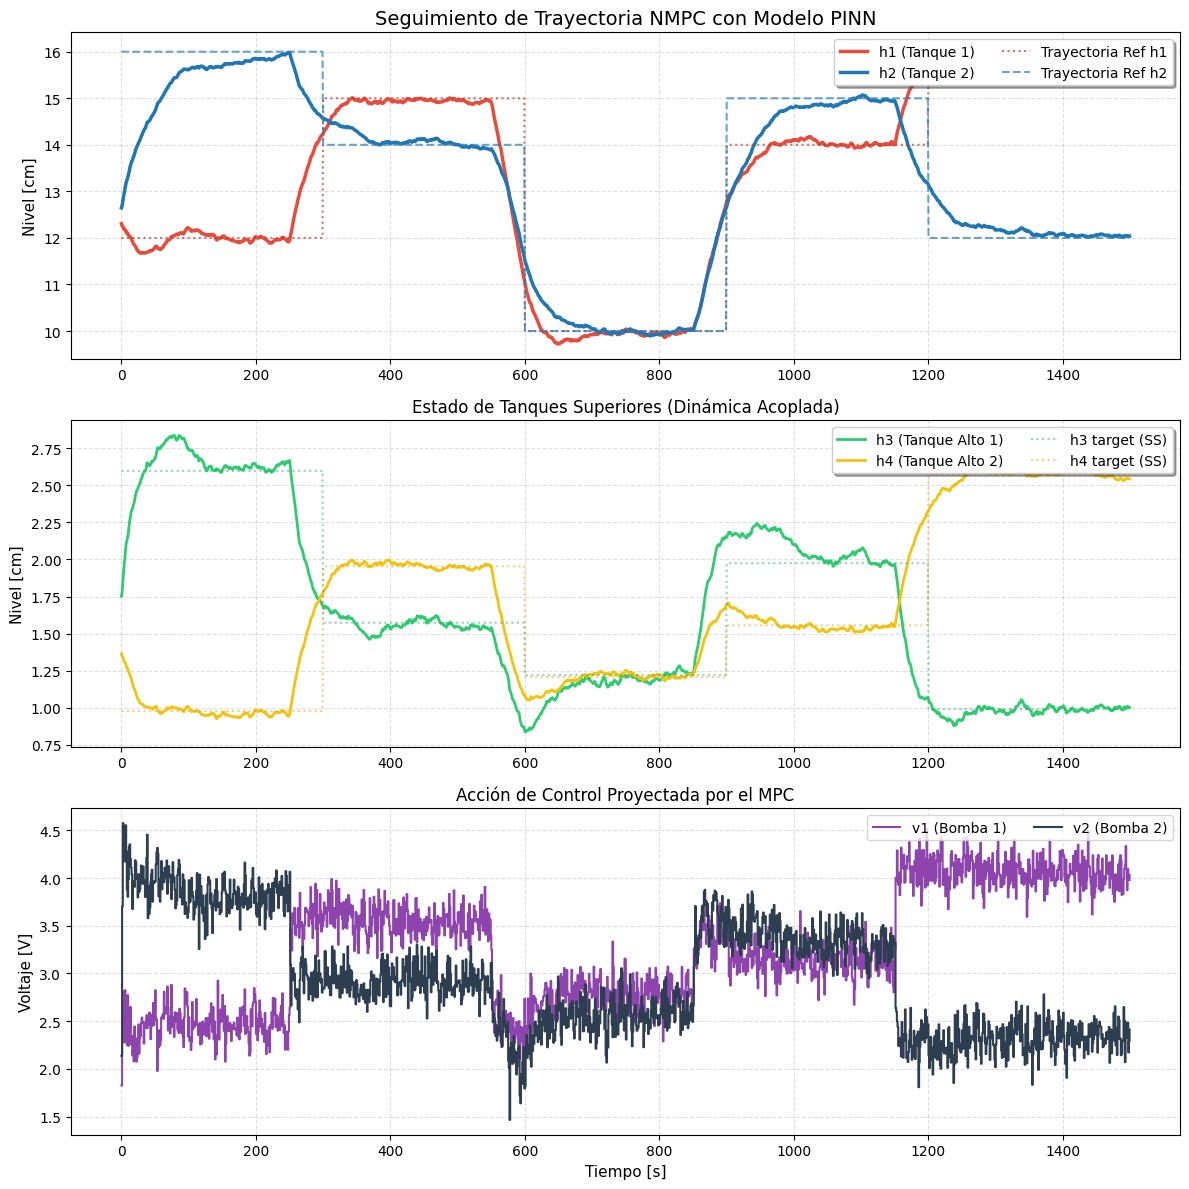

In [113]:
# Re-cálculo del eje del tiempo basado en los pasos reales ejecutados
history_t = np.arange(0, len(history_h)) * dt_control

# Figura de visualización de resultados
plt.figure(figsize=(12, 12), facecolor='white')

# 1. TANQUES INFERIORES (h1, h2) vs REFERENCIA DINÁMICA SELECCIONADA
plt.subplot(3, 1, 1)
plt.plot(history_t, history_h[:, 0], color='#e74c3c', linewidth=2.5, label='h1 (Tanque 1)')
plt.plot(history_t, history_h[:, 1], color='#1f77b4', linewidth=2.5, label='h2 (Tanque 2)')

# Gráfica de la referencia que el MPC intentó seguir
plt.plot(history_t, history_ref[:, 0], color='#c0392b', linestyle=':', linewidth=1.5, alpha=0.7, label='Trayectoria Ref h1')
plt.plot(history_t, history_ref[:, 1], color='#2980b9', linestyle='--', linewidth=1.5, alpha=0.7, label='Trayectoria Ref h2')

plt.ylabel('Nivel [cm]', fontsize=11)
plt.title('Seguimiento de Trayectoria NMPC con Modelo PINN', fontsize=14)
plt.legend(loc='upper right', ncol=2, frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.4)

# 2. TANQUES SUPERIORES (h3, h4) - Respuesta al Acoplamiento
plt.subplot(3, 1, 2)
plt.plot(history_t, history_h[:, 2], color='#2ecc71', linewidth=2, label='h3 (Tanque Alto 1)')
plt.plot(history_t, history_h[:, 3], color='#f1c40f', linewidth=2, label='h4 (Tanque Alto 2)')

plt.plot(history_t, history_ref[:, 2], color='#27ae60', linestyle=':', alpha=0.5, label='h3 target (SS)')
plt.plot(history_t, history_ref[:, 3], color='#f39c12', linestyle=':', alpha=0.5, label='h4 target (SS)')

plt.ylabel('Nivel [cm]', fontsize=11)
plt.title('Estado de Tanques Superiores (Dinámica Acoplada)', fontsize=12)
plt.legend(loc='upper right', ncol=2, frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.4)

# 3. ACCIÓN DE CONTROL (Esfuerzo de las Bombas)
plt.subplot(3, 1, 3)
plt.step(history_t, history_v[:, 0], color='#8e44ad', linewidth=1.5, where='post', label='v1 (Bomba 1)')
plt.step(history_t, history_v[:, 1], color='#2c3e50', linewidth=1.5, where='post', label='v2 (Bomba 2)')
plt.ylabel('Voltaje [V]', fontsize=11)
plt.xlabel('Tiempo [s]', fontsize=11)
plt.title('Acción de Control Proyectada por el MPC', fontsize=12)
plt.legend(loc='upper right', ncol=2)
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [114]:
import pandas as pd

# 1. Consolidación de vectores
# history_h: (Pasos, 4) -> niveles
# history_ref: (Pasos, 4) -> referencias
# history_v: (Pasos, 2) -> voltajes
data_control = {
    'Tiempo [s]': history_t,
    # Niveles Reales
    'h1_Real': history_h[:, 0],
    'h2_Real': history_h[:, 1],
    'h3_Real': history_h[:, 2],
    'h4_Real': history_h[:, 3],
    # Referencias (Setpoints)
    'h1_Ref': history_ref[:, 0],
    'h2_Ref': history_ref[:, 1],
    'h3_Ref': history_ref[:, 2],
    'h4_Ref': history_ref[:, 3],
    # Acciones de Control (Voltajes)
    'v1_Control': history_v[:, 0],
    'v2_Control': history_v[:, 1]
}

# 2. Creación del DataFrame
df_control = pd.DataFrame(data_control)

# 3. Guardado (Sugerencia: usar un nombre que identifique el modelo usado, ej. PINN o EDMD)
nombre_csv = 'control_lazo_cerrado_PINN.csv' 
df_control.to_csv(nombre_csv, index=False)

print(f"✅ Datos de control guardados en: {nombre_csv}")

✅ Datos de control guardados en: control_lazo_cerrado_PINN.csv


In [ ]:
# --- CÁLCULO DE MÉTRICAS DE APRENDIZAJE Y CONTROL (VERSION PINN-NMPC) ---

# 1. Errores de seguimiento en los tanques inferiores (Variables controladas)
error_h1 = history_h[:, 0] - history_ref[:, 0]
error_h2 = history_h[:, 1] - history_ref[:, 1]
error_h3 = history_h[:, 2] - history_ref[:, 2]
error_h4 = history_h[:, 3] - history_ref[:, 3]
error_full = np.concatenate((error_h1, error_h2, error_h3, error_h4))

# 2. Métricas Estadísticas de Precisión
MSE = np.mean(error_full**2)
RMSE = np.sqrt(MSE)
MAE = np.mean(np.abs(error_full))
SSE = np.sum(error_full**2)

# 3. Cálculo de VAF (Variance Fraction) - Mide qué tanto la PINN capturó la tendencia real
var_ref = np.var(np.concatenate((history_ref[:, 0], history_ref[:, 1], history_ref[:, 2], history_ref[:, 3])))
VAF = max(0, (1 - np.var(error_full) / var_ref) * 100)

# 4. Error cuadrático medio normalizado (NRMSE) - Escala el error al rango de operación
h_real_concat = np.concatenate((history_h[:, 0], history_h[:, 1]))
range_h = np.max(h_real_concat) - np.min(h_real_concat)
NRMSE = RMSE / range_h if range_h > 1e-6 else 0.0

# 5. Esfuerzo de control acumulado (Mide la suavidad de las bombas v1, v2)
# Un esfuerzo alto indica que las bombas oscilaron demasiado (jitter)
control_effort = np.sum(np.abs(np.diff(history_v, axis=0)))

# --- IMPRESIÓN DEL REPORTE INTEGRADO ---
print("\n" + "═"*75)
print(f"{'REPORTE INTEGRADO DE EVALUACIÓN: MODELO PINN (NMPC)':^75}")
print("═"*75)
print(f"MSE (Error Cuadrático Medio global)    : {MSE:.6e} cm²")
print(f"RMSE (Raíz del Error Cuadrático Medio) : {RMSE:.6e} cm")
print(f"MAE (Error Absoluto Medio global)      : {MAE:.6e} cm")
print(f"SSE (Suma del Error Cuadrático global) : {SSE:.6e} cm²")
print(f"NRMSE (Error Normalizado global)       : {NRMSE:.6e}")
print(f"VAF (Fidelidad de Seguimiento PINN)    : {VAF:.2f} %")
print("-" * 75)
print(f"Esfuerzo de Control Total (ΔV Acumulado): {control_effort:.2f} V")
print("═"*75)


═══════════════════════════════════════════════════════════════════════════
            REPORTE INTEGRADO DE EVALUACIÓN: MODELO PINN (NMPC)            
═══════════════════════════════════════════════════════════════════════════
MSE (Error Cuadrático Medio global)    : 3.292985e-02 cm²
RMSE (Raíz del Error Cuadrático Medio) : 1.814658e-01 cm
MAE (Error Absoluto Medio global)      : 1.532709e-01 cm
SSE (Suma del Error Cuadrático global) : 1.975791e+02 cm²
NRMSE (Error Normalizado global)       : 2.929925e-02
VAF (Fidelidad de Seguimiento PINN)    : 99.92 %
---------------------------------------------------------------------------
Esfuerzo de Control Total (ΔV Acumulado): 455.44 V
═══════════════════════════════════════════════════════════════════════════


## Fidelidad dinámica de los tanques inferiores: PINN + MPC vs Simulación


Calculando Ground Truth físico (RK45) para verificar precisión del MPC...


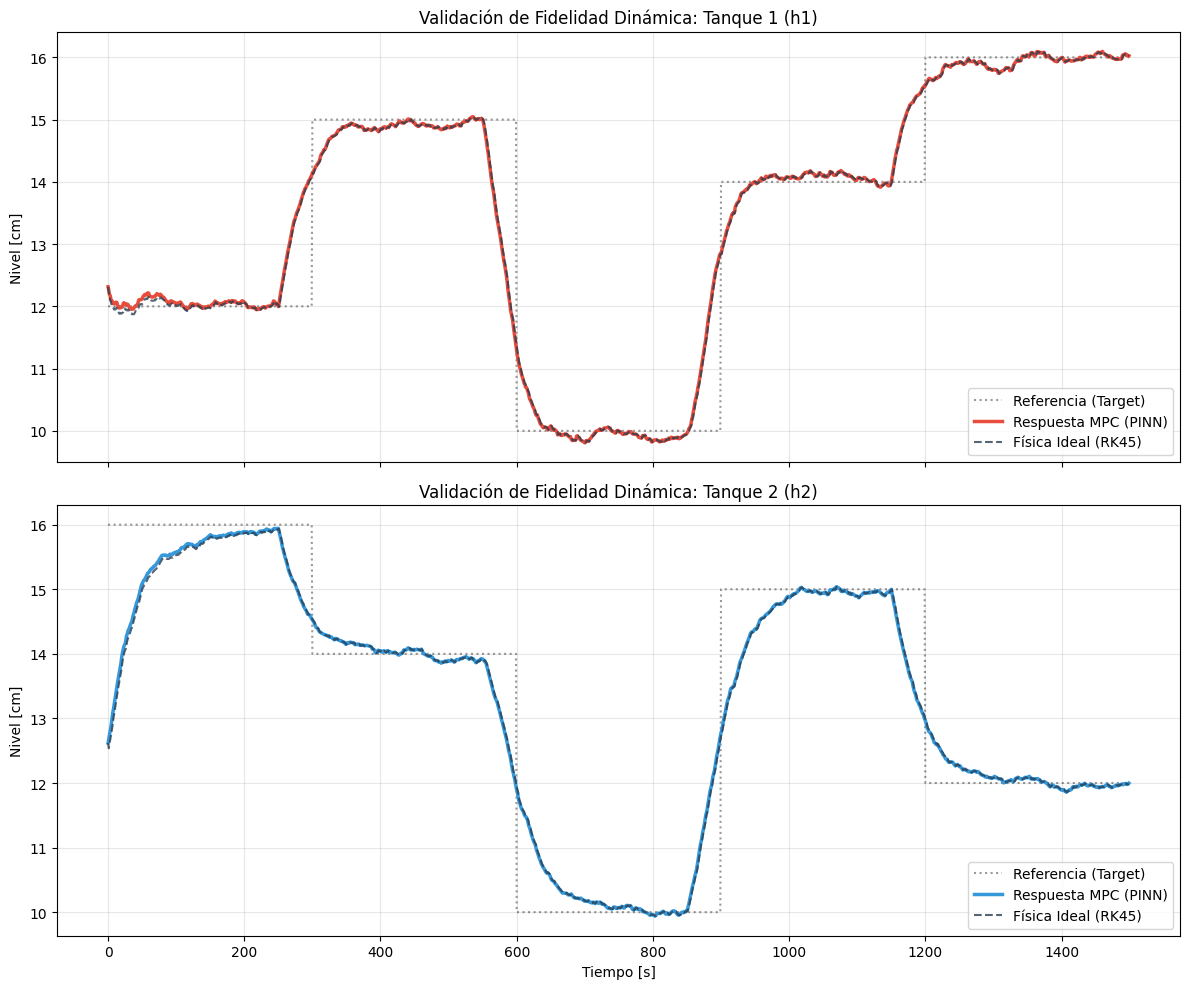

Desviación Media entre PINN y RK45: 0.01451 cm


In [ ]:
def validar_fidelidad_dinamica(history_t, history_v, history_h_pinn, history_ref, params):
    # 1. Reconstruir v1(t) y v2(t) mediante interpolación para la ODE continua
    v1_fun = interp1d(history_t, history_v[:, 0], kind='zero', fill_value='extrapolate')
    v2_fun = interp1d(history_t, history_v[:, 1], kind='zero', fill_value='extrapolate')

    # Desempaquetar parámetros físicos
    A1, A2, A3, A4 = params['A1'], params['A2'], params['A3'], params['A4']
    a1, a2, a3, a4 = params['a1'], params['a2'], params['a3'], params['a4']
    g, k1, k2 = params['g'], params['k1'], params['k2']
    gamma1, gamma2 = params['gamma1'], params['gamma2']

    # 2. Definición del sistema real para el validador
    def planta_real_val(t, h):
        h_s = np.maximum(h, 1e-6)
        v1, v2 = v1_fun(t), v2_fun(t)

        dh1 = -(a1/A1)*np.sqrt(2*g*h_s[0]) + (a3/A1)*np.sqrt(2*g*h_s[2]) + (gamma1*k1*v1)/A1
        dh2 = -(a2/A2)*np.sqrt(2*g*h_s[1]) + (a4/A2)*np.sqrt(2*g*h_s[3]) + (gamma2*k2*v2)/A2
        dh3 = -(a3/A3)*np.sqrt(2*g*h_s[2]) + ((1-gamma2)*k2*v2)/A3
        dh4 = -(a4/A4)*np.sqrt(2*g*h_s[3]) + ((1-gamma1)*k1*v1)/A4
        return [dh1, dh2, dh3, dh4]

    # 3. Integración de Referencia (Ground Truth)
    print("Calculando Ground Truth físico (RK45) para verificar precisión del MPC...")
    sol_val = solve_ivp(planta_real_val, [history_t[0], history_t[-1]], history_h_pinn[0],
                        method='RK45', t_eval=history_t, rtol=1e-8, atol=1e-8)

    h_fisica_rk45 = sol_val.y.T

    # 4. Gráfica Comparativa Triple
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Tanque 1 (h1)
    ax1.plot(history_t, history_ref[:, 0], 'k:', alpha=0.4, label='Referencia (Target)')
    ax1.plot(history_t, history_h_pinn[:, 0], color='#e74c3c', label='Respuesta MPC (PINN)', linewidth=2.5)
    ax1.plot(history_t, h_fisica_rk45[:, 0], color='#2c3e50', linestyle='--', alpha=0.8, label='Física Ideal (RK45)')
    ax1.set_title('Validación de Fidelidad Dinámica: Tanque 1 (h1)')
    ax1.set_ylabel('Nivel [cm]')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)

    # Tanque 2 (h2)
    ax2.plot(history_t, history_ref[:, 1], 'k:', alpha=0.4, label='Referencia (Target)')
    ax2.plot(history_t, history_h_pinn[:, 1], color='#3498db', label='Respuesta MPC (PINN)', linewidth=2.5)
    ax2.plot(history_t, h_fisica_rk45[:, 1], color='#2c3e50', linestyle='--', alpha=0.8, label='Física Ideal (RK45)')
    ax2.set_title('Validación de Fidelidad Dinámica: Tanque 2 (h2)')
    ax2.set_ylabel('Nivel [cm]')
    ax2.set_xlabel('Tiempo [s]')
    ax2.legend(loc='lower right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Cálculo del error entre lo que el MPC cree y la realidad física
    error_modelo = np.mean(np.abs(history_h_pinn - h_fisica_rk45))
    print(f"Desviación Media entre PINN y RK45: {error_modelo:.5f} cm")

    return h_fisica_rk45

# Ejecutar validación
h_fisica_full = validar_fidelidad_dinamica(history_t, history_v, history_h, history_ref, params_mpc)

## Fidelidad dinámica de los tanques inferiores: PINN + MPC vs Simulación


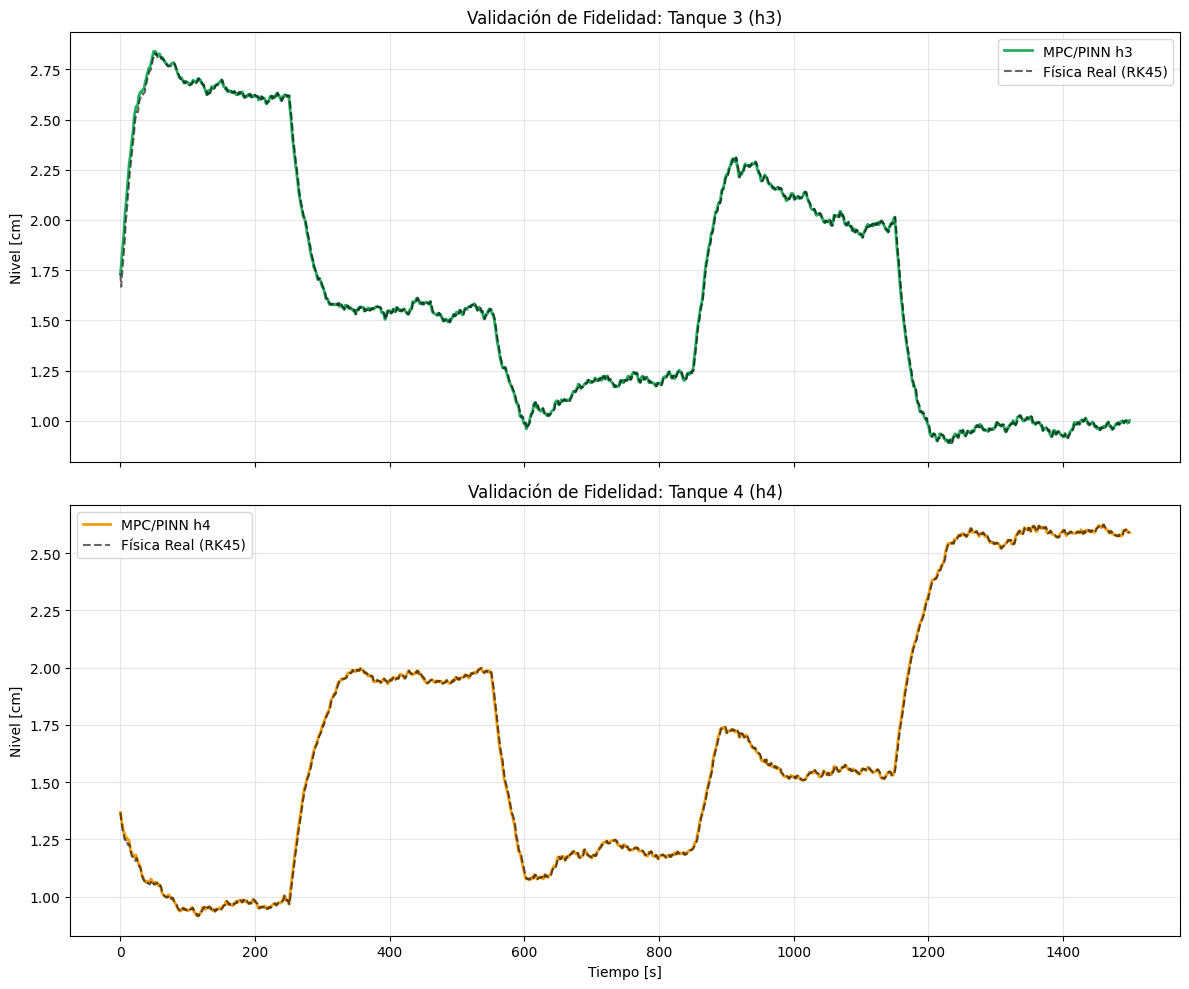


       INFORME DE FIDELIDAD PINN (4 TANQUES)
Error medio h1: 0.021643 cm
Error medio h2: 0.021619 cm
Error medio h3: 0.009150 cm
Error medio h4: 0.005632 cm
FIDELIDAD GLOBAL: 99.9855%


In [ ]:
def validar_fisica_superior(history_t, history_h_pinn, h_fisica_rk45):
    fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Tanque 3
    ax3.plot(history_t, history_h_pinn[:, 2], color='#27ae60', label='MPC/PINN h3', linewidth=2)
    ax3.plot(history_t, h_fisica_rk45[:, 2], 'k--', alpha=0.6, label='Física Real (RK45)')
    ax3.set_title('Validación de Fidelidad: Tanque 3 (h3)')
    ax3.set_ylabel('Nivel [cm]')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Tanque 4
    ax4.plot(history_t, history_h_pinn[:, 3], color='#f39c12', label='MPC/PINN h4', linewidth=2)
    ax4.plot(history_t, h_fisica_rk45[:, 3], 'k--', alpha=0.6, label='Física Real (RK45)')
    ax4.set_title('Validación de Fidelidad: Tanque 4 (h4)')
    ax4.set_ylabel('Nivel [cm]')
    ax4.set_xlabel('Tiempo [s]')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- INFORME FINAL DE COHERENCIA FÍSICA ---
    maes = np.mean(np.abs(history_h_pinn - h_fisica_rk45), axis=0)

    print(f"\n" + "="*50)
    print(f"       INFORME DE FIDELIDAD PINN (4 TANQUES)")
    print(f"="*50)
    print(f"Error medio h1: {maes[0]:.6f} cm")
    print(f"Error medio h2: {maes[1]:.6f} cm")
    print(f"Error medio h3: {maes[2]:.6f} cm")
    print(f"Error medio h4: {maes[3]:.6f} cm")
    print(f"FIDELIDAD GLOBAL: {100 - np.mean(maes):.4f}%")
    print(f"="*50)

# Ejecutar parte 2
validar_fisica_superior(history_t, history_h, h_fisica_full)